# Proceso de analítica y exploración de los datos de muestra del SDC3

## 1.Importación de librerías y carga de datos

### 1.1 Librerías

In [62]:
import matplotlib.pyplot as plt
import random
from astropy.io import fits
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm
import seaborn as sns
from random import shuffle
from scipy.stats import bartlett

In [63]:
path_datos="/home/21953404Victor/SDC3/SDC3GIT/data/"

### 1.2 Carga de datos
#### 1.2.1 ZW2.msw_image.fits
uniform weighting data cube

In [64]:
path =path_datos+ "ZW2.msw_image.fits"
hdul = fits.open(path)
print(hdul.info())

Filename: /home/21953404Victor/SDC3/SDC3GIT/data/ZW2.msw_image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      69   (2048, 2048, 901)   float32   
None


#### 1.2.2 ZW2.msn_image.fits y ZW2.msn_psf.fits
natural weighting data cube 
PSF: función de dispersión de punto en español. Es una función que describe la respuesta de un sistema óptico enfocado a una fuente o un objeto puntual. La PSF es una medida de la calidad y la resolución del sistema óptico.

In [65]:
path2 = path_datos+"ZW2.msn_image.fits"
path3 = path_datos+"ZW2.msn_psf.fits"
hdul2 = fits.open(path2)
hdul3 = fits.open(path3)
print("Descripción de la imagen")
print(hdul2.info())
print("------------------------")
print("Descripción del psf")
print(hdul3.info())

Descripción de la imagen
Filename: /home/21953404Victor/SDC3/SDC3GIT/data/ZW2.msn_image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      67   (2048, 2048, 901)   float32   
None
------------------------
Descripción del psf
Filename: /home/21953404Victor/SDC3/SDC3GIT/data/ZW2.msn_psf.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      65   (2048, 2048, 901)   float32   
None


## 2. Funciones frecuentes

##### 2.1 Mostrar imagenes
 La función mostrar_imagenes toma un arreglo de imágenes y muestra algunas de ellas en una figura con diferentes paletas de colores. Puedes elegir cuántas imágenes mostrar y en qué posiciones del arreglo. La función usa matplotlib para crear la figura y mostrar las imágenes con imshow. También le pone un título y una barra de color a cada imagen.
 Paletas recomendadas: coolwarm, seismic, PiYG o Spectral (sobre todo Spectral)

In [66]:
def mostrar_imagenes(cubo, numero_imagenes=3, posiciones=[],pcmap='Spectral'):
    if len(posiciones) == 0:
        posiciones = sorted(random.sample(range(0, len(cubo)), numero_imagenes))
    else:
        numero_imagenes = len(posiciones)
        
    fig, axs = plt.subplots(numero_imagenes, 1, figsize=(30, 30))
    fig.patch.set_facecolor('lightgray')
    
    fig.suptitle("Ejemplo de "+str(numero_imagenes)+" imágenes de la muestra",x=0.63,y=0.91, fontsize=20, fontdict={'color':'black', 'weight':'bold', 'horizontalalignment':'center'})
    
    for i in range(len(posiciones)):
        im = axs[i].imshow(cubo[posiciones[i]], cmap=pcmap)
        axs[i].set_title('Imagen en la posición ' + str(posiciones[i]) + ' con paleta ' + pcmap)
        fig.colorbar(im, ax=axs[i])
    return (plt.show()) 

##### 2.2 Muestra aleatoria

Esta función recibe como argumento un cubo de imágenes astrofísicas y devuelve un gráfico que muestra la distribución normal de los valores atípicos en una imagen aleatoria del cubo.

Primero, se selecciona una posición aleatoria del cubo y se extrae la imagen correspondiente. Luego, se convierte la imagen en un vector de una dimensión y se calcula el valor medio y la desviación estándar del vector.

A continuación, se define un umbral para identificar los valores atípicos como aquellos que están a más o menos tres desviaciones estándar del valor medio. Se crea un vector con los valores atípicos y se muestra su tamaño y forma.

Después, se genera un gráfico de distribución normal usando las librerías numpy, scipy y matplotlib. Se usa la función norm.pdf() de scipy.stats para crear una curva gaussiana ideal con la misma media y desviación estándar que el vector de valores atípicos. Se usa la función hist() de matplotlib.pyplot para mostrar el histograma de los valores atípicos con 20 intervalos. Se usa la función plot() de matplotlib.pyplot para mostrar la curva gaussiana sobre el histograma. Se añaden los títulos, nombres de ejes y leyenda al gráfico usando las funciones title(), xlabel(), ylabel() y legend() de matplotlib.pyplot.

Finalmente, se muestra el gráfico usando la función show() de matplotlib.pyplot.

In [67]:
def muestra_aleatoria(cubo):
    numim=len(cubo)
    randompos=random.randrange(numim)
    print("Número de imágenes: "+str(numim)+"\n\nMuestra aleatoria de ejemplo, imagen: "+str(randompos)+"\n",cubo[randompos])
    print("Tamaño de la imagen: "+str(cubo[randompos].shape))
    # Convertir la imagen en un vector unidimensional
    image_vector = cubo[randompos].flatten()
    # Convertir el vector de numpy en una serie de pandas con tipo de datos float64
    image_vector = pd.Series(image_vector, dtype=np.float64)
    print("\nDescripción del vector de la imagen:\n",image_vector.describe())
    # Contar los valores nulos antes de eliminarlos
    null_count_before = image_vector.isnull().sum()
    # Eliminar los valores nulos del vector
    image_vector = image_vector.dropna()
    null_count_after = image_vector.isnull().sum()
    print("Se han eliminado " + str(null_count_before - null_count_after) + " valores nulos.")
    # estadísticas básicas del vector
    stats = image_vector.describe()
    # rango intercuartílico (IQR)
    iqr = stats["75%"] - stats["25%"]
    # límites inferior y superior para detectar outliers
    lower_bound = stats["25%"] - 1.5 * iqr
    upper_bound = stats["75%"] + 1.5 * iqr
    # valores típicos o atípicos
    typical_values = image_vector[(image_vector >= lower_bound) & (image_vector <= upper_bound)]
    outlier_values = image_vector[(image_vector < lower_bound) | (image_vector > upper_bound)]

    #GRÁFICOS
    print("\nRepresentación de la distribución de la muestra")
    fig, ax = plt.subplots(3,1,figsize=(10, 8)) 
    fig.suptitle("Distribución de la muestra aleatoria: posición "+str(randompos),x=0.5,y=0.99, fontsize=20, fontdict={'color':'black', 'weight':'bold', 'horizontalalignment':'center'})
    fig.patch.set_facecolor('lightgray')
    # boxplot de la muestra aleatoria
    ax[0].boxplot(image_vector, vert=False) 
    ax[0].set_title("Boxplot de toda la muestra aleatoria") 
    ax[0].set_xlabel("Valor del píxel")
    # boxplot de los valores típicos
    plt.subplots_adjust(hspace=0.5)
    sns.boxplot(x=typical_values, color="blue", ax=ax[1]) 
    ax[1].set_title("Boxplot de los valores típicos en la muestra aleatoria") 
    ax[1].set_xlabel("Valor del píxel") 
    # Distribucion de los valores atípicos
    data = np.random.normal(0, 1, 1000) # Crear una muestra aleatoria de 1000 valores con media 0 y desviación estándar 1
    mean = np.mean(data)
    std = np.std(data)
    x_axis = np.linspace(mean - 3*std, mean + 3*std, 1000)# eje x para el gráfico de la curva gaussiana
    y_axis = norm.pdf(x_axis, mean, std) # curva gaussiana
    # Mostrar el histograma de los datos y la curva gaussiana
    ax[2].hist(data, bins=20, density=True)
    ax[2].plot(x_axis, y_axis)
    ax[2].set_title("Distribución normal de los valores atípicos en la muestra aleatoria")
    ax[2].set_xlabel("Valor del píxel")
    ax[2].set_ylabel("Densidad")
    ax[2].legend(["Curva gaussiana ajustada", "Histograma de los valores atípicos"], fontsize=10, loc="upper center", bbox_to_anchor=(0.5, -0.5))
    fig.subplots_adjust(hspace=1)
    plt.show() # Mostrar la figura completa

##### 2.3 Análisis estadístico

##### 2.3.1 Filtrado de valores atípicos

In [68]:
def iqr_filter(imagen):
  image_vector = imagen.flatten()
  # Convertir el vector de numpy en una serie de pandas con tipo de datos float64
  image_vector = pd.Series(image_vector, dtype=np.float64)
  stats = image_vector.describe()
  # rango intercuartílico (IQR)
  iqr = stats["75%"] - stats["25%"]
  # límites inferior y superior para detectar outliers
  lower_bound = stats["25%"] - 1.5 * iqr
  upper_bound = stats["75%"] + 1.5 * iqr
  return image_vector[(image_vector < lower_bound) | (image_vector > upper_bound)]

def filtrar_cubo(cubo, len_muestra=4):
  # Supongamos que tu array se llama images
  filtered_images = []
  # Elige len_muestra imágenes de manera aleatoria
  sample_images = random.sample(range(len(cubo)), len_muestra)
  sample_images=sorted(sample_images)
  for i in sample_images:
    # Filtra la imagen
    filtered_image = iqr_filter(cubo[i])
    filtered_images.append(filtered_image)
  return filtered_images

##### 2.3.1 Test de Barlett
 La prueba de Bartlett es un método estadístico para comprobar si la varianza entre varios grupos es igual

In [69]:
def test_bartlett(filtered_images, alpha=0.05):
    shuffle(filtered_images) # Divide el array en dos grupos
    mitad = len(filtered_images) // 2
    group1 = filtered_images[:mitad]
    group2 = filtered_images[mitad:]
    g1_unidireccional = np.concatenate(group1)
    g2_unidireccional = np.concatenate(group2)

    # Aplica la prueba de Bartlett
    statistic, pvalue = bartlett(g1_unidireccional, g2_unidireccional)

    # Interpreta el resultado
    if pvalue < alpha:
        print(f"Las varianzas son significativamente diferentes (p={pvalue:.4f}).")
        print(f"Se rechaza la hipótesis nula de homocedasticidad con un nivel de significancia de {alpha}.")
    else:
        print(f"Las varianzas no son significativamente diferentes (p={pvalue:.4f}).")
        print(f"Se acepta la hipótesis nula de homocedasticidad con un nivel de significancia de {alpha}.")


##### 2.3.1 Test de Welch
La prueba t de Welch es un método estadístico para comparar las medias de dos grupos que pueden tener varianzas diferentes

In [70]:
def test_welch (filtered_images, alpha=0.05):
    shuffle(filtered_images)
    # Divide el array en dos grupos
    mitad = len(filtered_images) // 2
    group1 = filtered_images[:mitad]
    group2 = filtered_images[mitad:]

    g1_unidireccional = np.concatenate(group1)
    g2_unidireccional = np.concatenate(group2)
 
    # Aplica la prueba de Welch
    statistic, pvalue = stats.ttest_ind(g1_unidireccional, g2_unidireccional, equal_var=False)
    # Interpreta el resultado
    if pvalue < alpha:
        print(f"Rechazamos la hipótesis nula de que las medias son iguales. \nHay evidencia suficiente para afirmar que las medias son significativamente diferentes con un nivel de confianza del {100*(1-alpha)}%.")
    else:
        print(f"No rechazamos la hipótesis nula de que las medias son iguales. \nNo hay evidencia suficiente para afirmar que las medias son significativamente diferentes con un nivel de confianza del {100*(1-alpha)}%.")

##### 2.4 Gráfico 3D
El código hace un gráfico 3D de los datos y los colorea según si son atípicos o no. Usa las bibliotecas matplotlib.pyplot y numpy para hacer los cálculos y el gráfico. Tiene dos opciones para rotar el gráfico o no.

In [71]:
def graf_3d(data,atipicos=True,rotate=False, angulo_rotacion=90, invertir_z=False, sufix=""):
    f,x,y=np.mgrid[:data.shape[0],:data.shape[1],:data.shape[2]]
    fig = plt.figure(figsize=(10, 10)) # crea una figura
    ax = fig.add_subplot(111, projection='3d') # crea un eje 3D
    title=""

    # Calcula la media y la desviación estándar de los datos
    mean = np.mean(data)
    std = np.std(data)

    # Define un umbral para los valores atípicos
    threshold = 3

    # Crea una máscara para los valores atípicos
    mask = np.abs(data - mean) > threshold * std

    if atipicos:
        color_scale = plt.cm.get_cmap('Spectral')
        colors = [color_scale(i) if mask.flatten()[j] else (0, 0, 0, 0) for j,i in enumerate(f.flatten())]
        ax.scatter(x,y,f,c=colors)
        title="Plot 3D solo para valores atípicos"
    else:
        ax.scatter(x,y,f,c = data.flatten(), alpha=0.9)
        title="Plot 3D para todos los valores"

     # hace un gráfico de puntos con los colores asignados
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Frecuencia')
    if rotate:
        ax.view_init(angulo_rotacion,0)
        title=title+" rotado "+str(angulo_rotacion)+" grados"
    if invertir_z:
        ax.invert_zaxis()
        title=title+"con eje Z invertido"

    title=title+" "+sufix
    ax.set_title(title)
    return ax 

## 3. Análisis exploratorio

### 3.1 Muestra ZW2.msw_image.fits

##### 3.1.1 Muestra aleatoria ZW2.msw_image.fits

Número de imágenes: 901

Muestra aleatoria de ejemplo, imagen: 337
 [[ 7.1108574e-05  4.7532165e-05  1.1381470e-05 ... -7.8569348e-05
  -7.0229020e-05 -4.2160580e-05]
 [ 5.7471389e-05  3.2415654e-05 -7.5237776e-06 ... -6.8434754e-05
  -9.2270064e-05 -7.8361190e-05]
 [ 4.3038148e-05  1.9646724e-05 -3.1409095e-06 ... -4.5693771e-05
  -9.0839880e-05 -9.8633151e-05]
 ...
 [ 4.9284554e-05  5.1492851e-05  4.0205803e-05 ...  2.5514224e-05
   4.5433767e-06 -3.2374595e-05]
 [ 1.6287157e-05  2.3642791e-05  2.7220431e-05 ...  5.0633404e-05
   1.4974472e-05 -3.9895298e-05]
 [-2.8544449e-05 -2.2077176e-05 -6.7238057e-06 ...  4.3448043e-05
  -9.3290299e-07 -5.4801341e-05]]
Tamaño de la imagen: (2048, 2048)

Descripción del vector de la imagen:
 count    4.194304e+06
mean     2.024066e-04
std      8.477629e-03
min     -7.088392e-03
25%     -6.764331e-05
50%      7.086228e-07
75%      7.060160e-05
max      2.899618e+00
dtype: float64
Se han eliminado 0 valores nulos.

Representación de la distribución

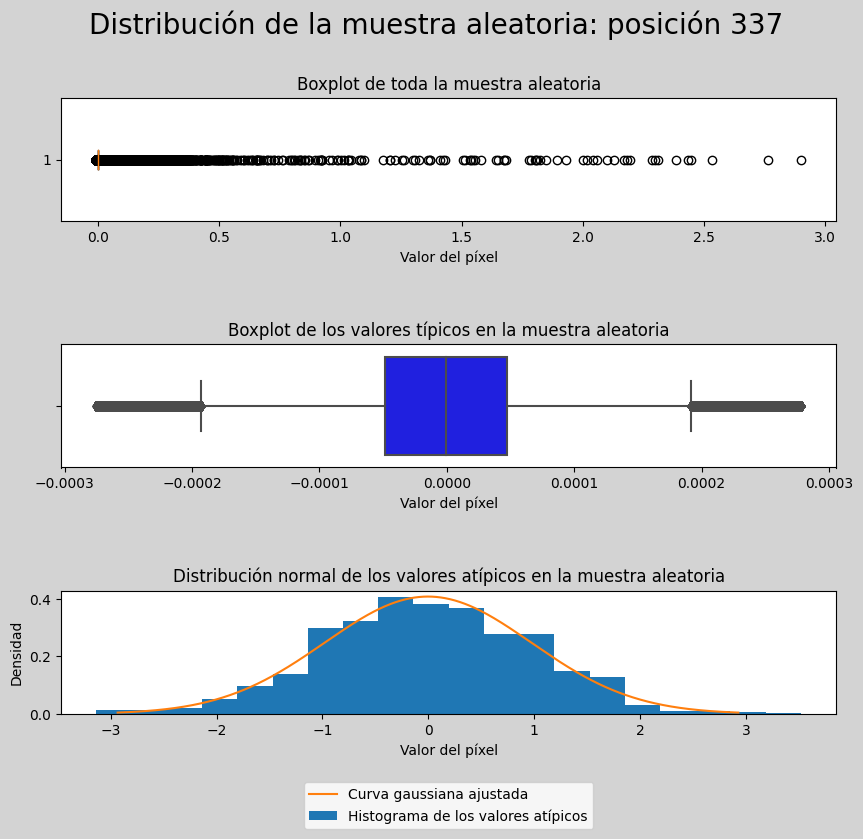

In [72]:
muestra_aleatoria(hdul[0].data) 

##### 3.1.2 Análisis de valores atípicos de ZW2.msw_image.fits

In [73]:
filtrado_atipicos=filtrar_cubo(hdul[0].data, len_muestra=16)

##### 3.1.2.1 Test Barlett

In [74]:
test_bartlett(filtrado_atipicos)

Las varianzas son significativamente diferentes (p=0.0000).
Se rechaza la hipótesis nula de homocedasticidad con un nivel de significancia de 0.05.


##### 3.1.2.1 Test Welch

In [75]:
test_welch(filtrado_atipicos)

Rechazamos la hipótesis nula de que las medias son iguales. 
Hay evidencia suficiente para afirmar que las medias son significativamente diferentes con un nivel de confianza del 95.0%.


##### 3.1.3 Imágenes de ZW2.msw_image.fits


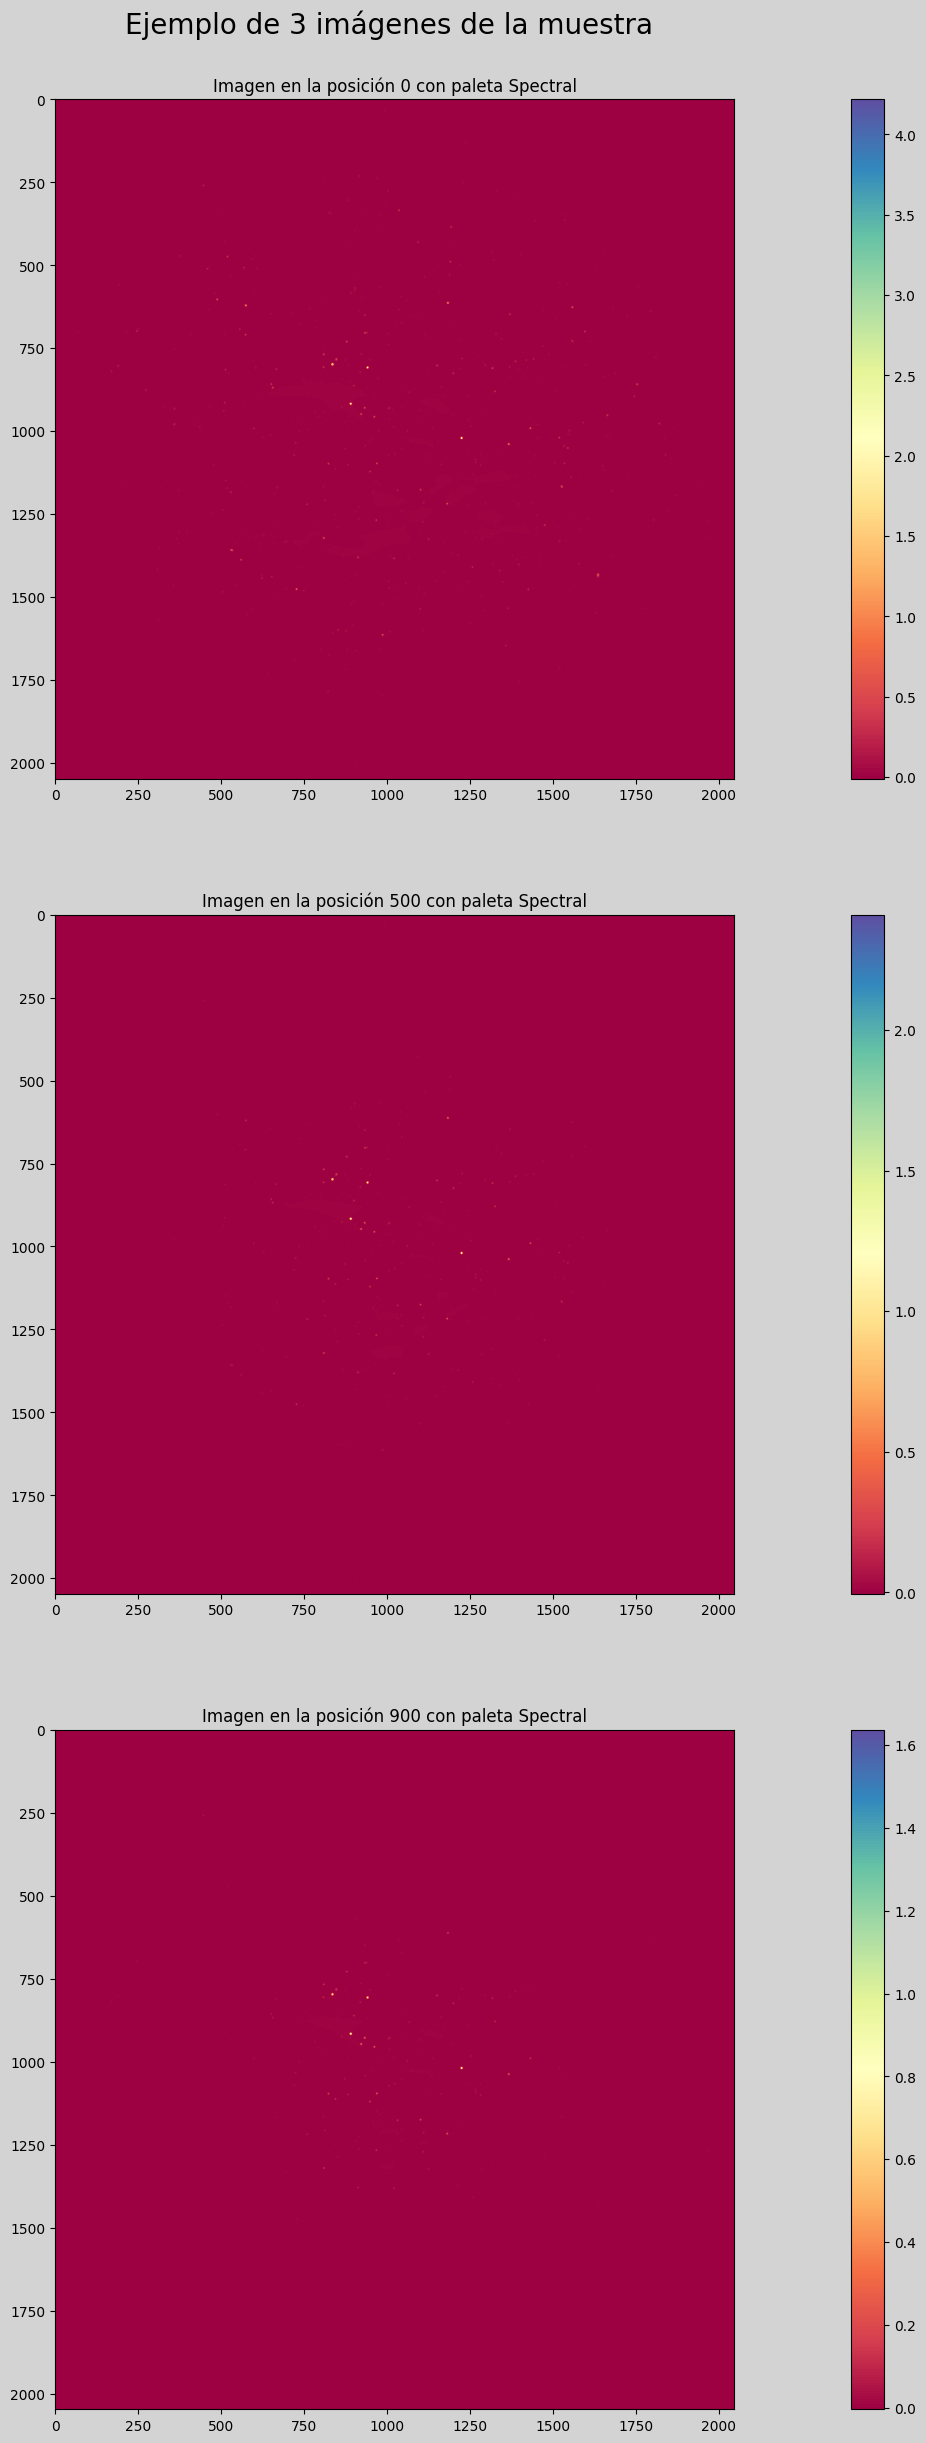

In [76]:
mostrar_imagenes(hdul[0].data,posiciones=[0,500,900])

##### 3.1.4 Estudio de fuentes de ZW2.msw_image.fits

Queremos hacer zoom en algungas fuentes para evaluar su tamaño y su distribución en un corte

Text(0.5, 1.0, 'Corte de fuente en coordenadas (764,708:718) en la imagen número 900')

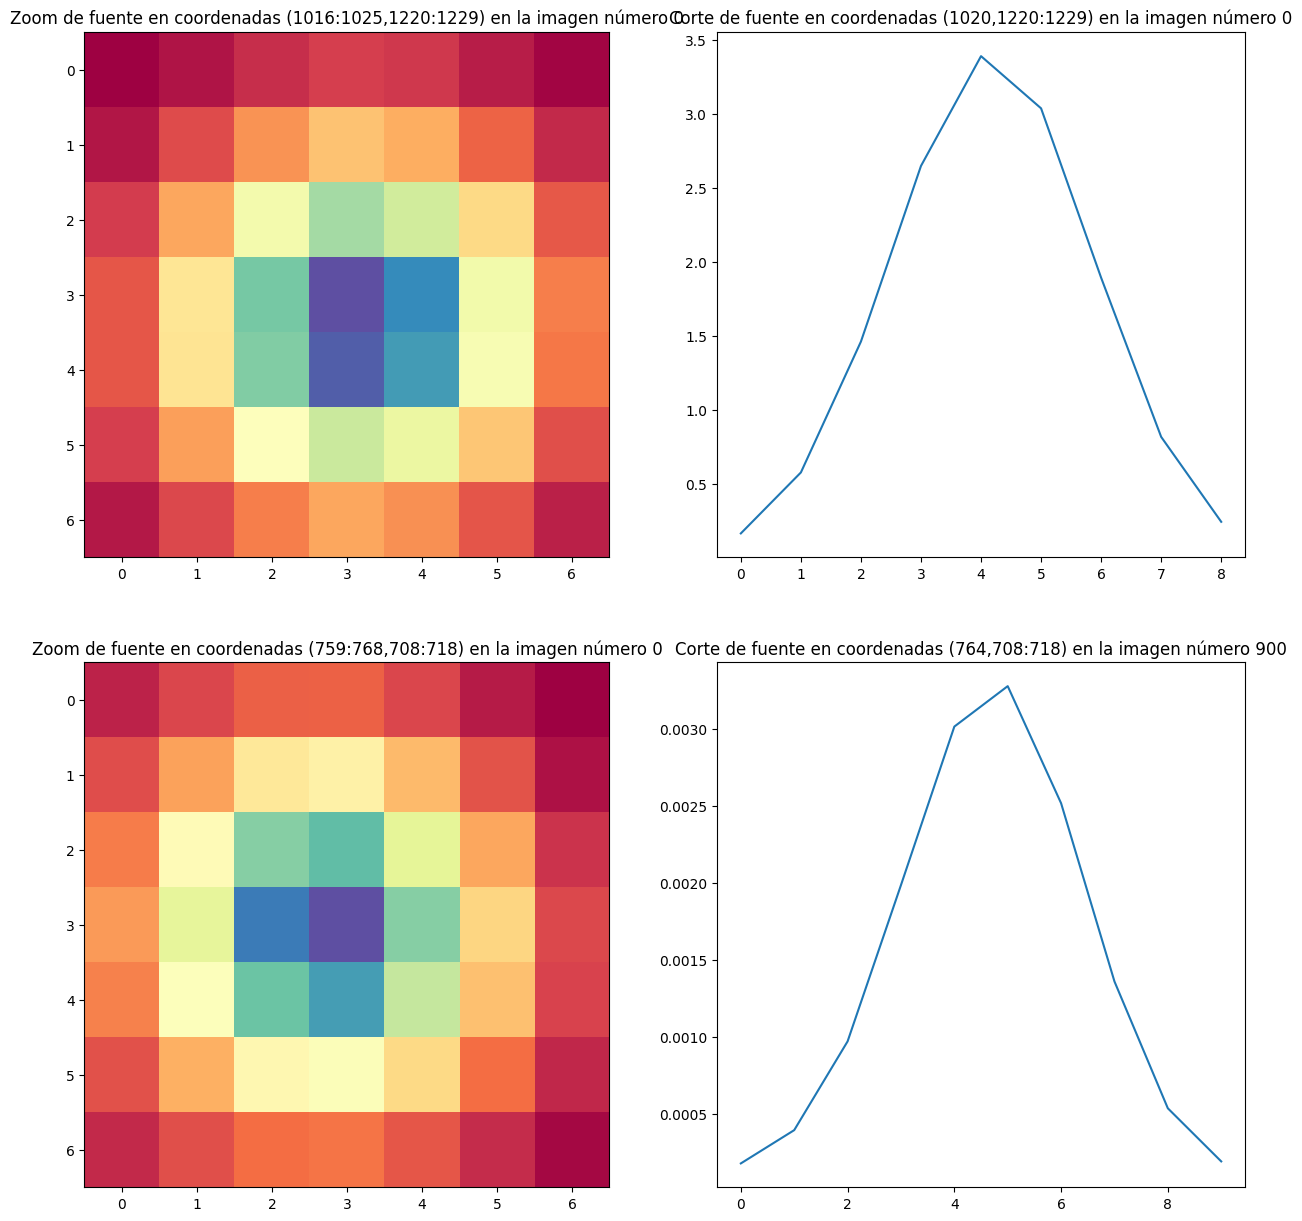

In [77]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

im1 = axs[0][0].imshow(hdul[0].data[0][1017:1024,1221:1228],cmap='Spectral')
axs[0][0].set_title('Zoom de fuente en coordenadas (1016:1025,1220:1229) en la imagen número 0')
im2=axs[0][1].plot(hdul[0].data[0][1020,1220:1229])
axs[0][1].set_title('Corte de fuente en coordenadas (1020,1220:1229) en la imagen número 0')

im3 = axs[1][0].imshow(hdul[0].data[900][760:767,710:717],cmap='Spectral')
axs[1][0].set_title('Zoom de fuente en coordenadas (759:768,708:718) en la imagen número 0')
im4=axs[1][1].plot(hdul[0].data[900][764,708:718])
axs[1][1].set_title('Corte de fuente en coordenadas (764,708:718) en la imagen número 900')

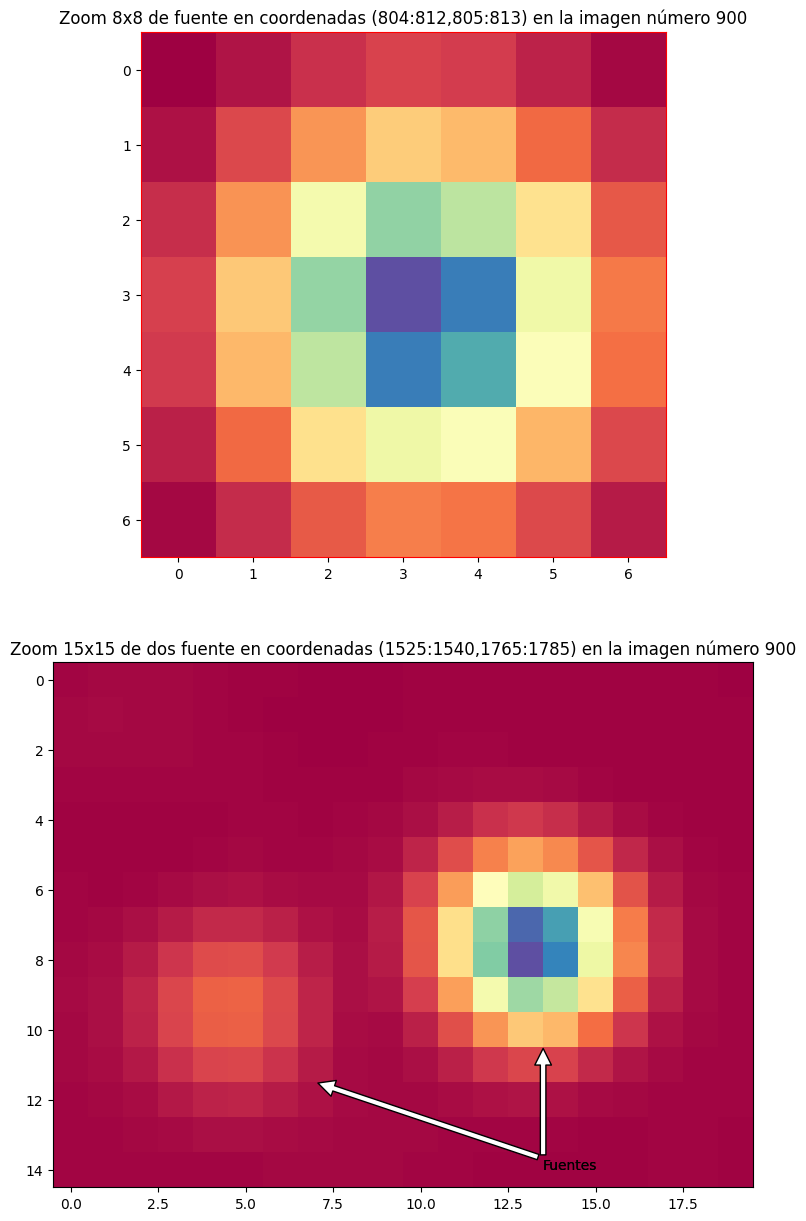

In [78]:
fig, axs = plt.subplots(2, 1, figsize=(15, 15))
im1=axs[0].imshow(hdul[0].data[900][804:811,805:812],cmap='Spectral')
axs[0].set_title('Zoom 8x8 de fuente en coordenadas (804:812,805:813) en la imagen número 900')
im2=axs[1].imshow(hdul[0].data[900][1525:1540,1765:1785],cmap='Spectral')
axs[1].set_title('Zoom 15x15 de dos fuente en coordenadas (1525:1540,1765:1785) en la imagen número 900')

# Añado un borde rojo al primer gráfico
axs[0].spines['top'].set_color('red')
axs[0].spines['bottom'].set_color('red')
axs[0].spines['left'].set_color('red')
axs[0].spines['right'].set_color('red')

# Añado una flecha y un texto al segundo gráfico
axs[1].annotate('Fuentes', xy=(13.5, 10.5), xytext=(13.5, 14), arrowprops=dict(facecolor='white', shrink=0.01))
axs[1].annotate('Fuentes', xy=(7, 11.5), xytext=(13.5, 14), arrowprops=dict(facecolor='white', shrink=0.01))
plt.show()

/tmp/ipykernel_3780219/1146068806.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_scale = plt.cm.get_cmap('Spectral')


<Axes3D: title={'center': 'Plot 3D solo para valores atípicos rotado 90 grados muestra 0:100,1000:1100,1200:1300 de ZW2.msw_image.fits'}, xlabel='X', ylabel='Y', zlabel='Frecuencia'>

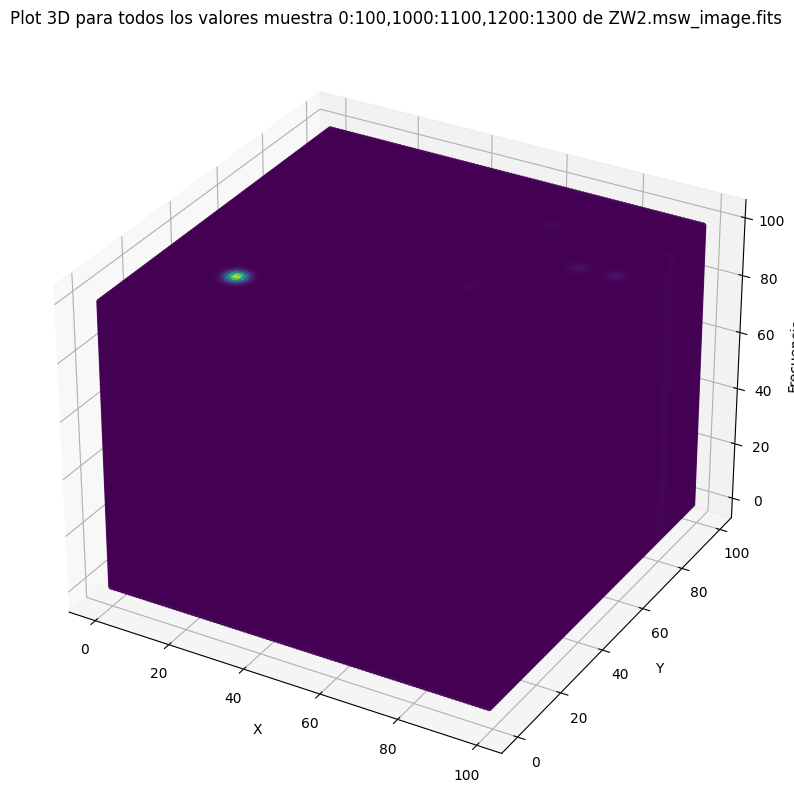

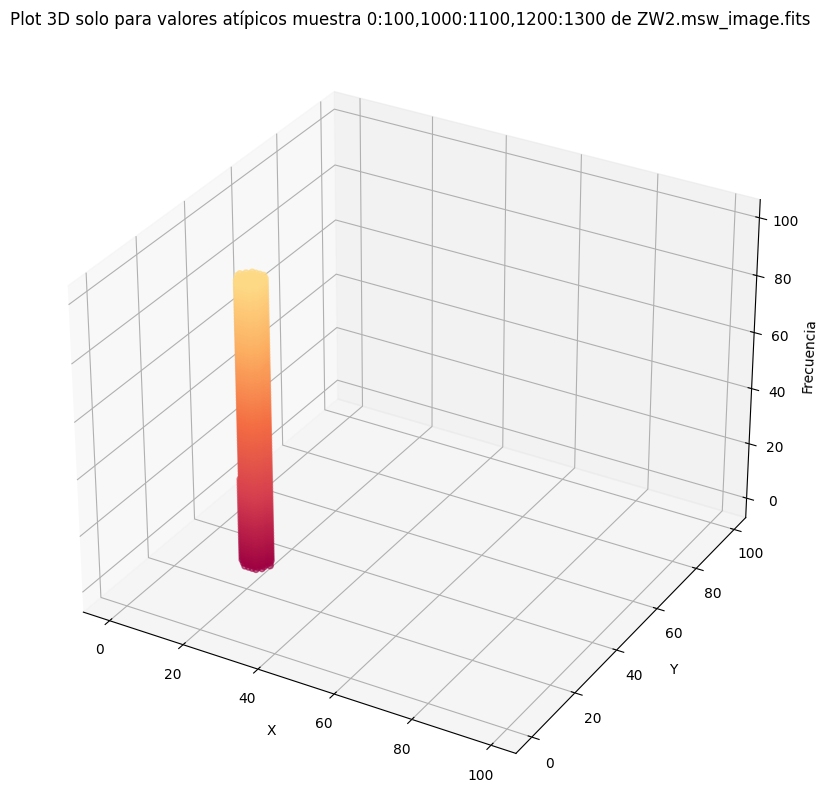

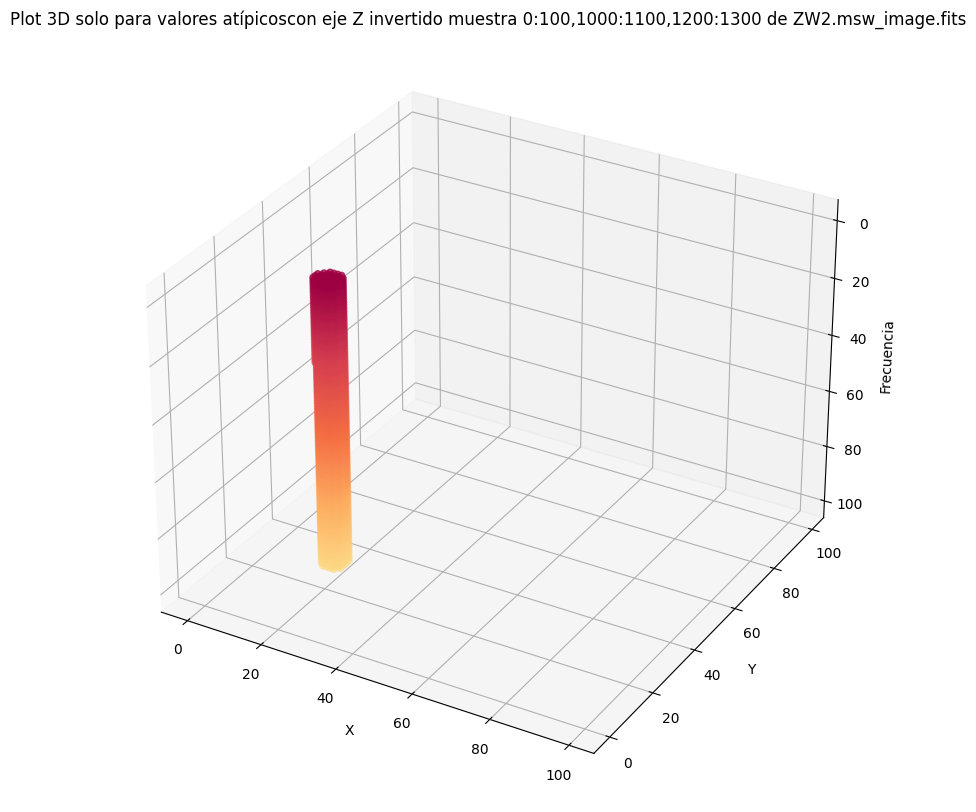

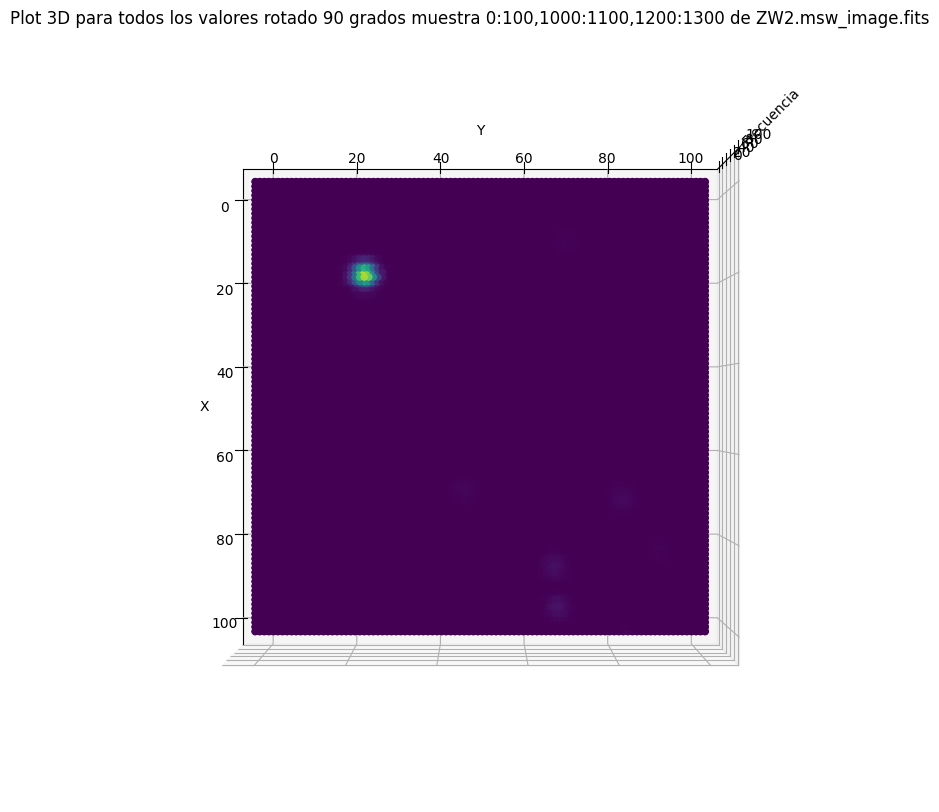

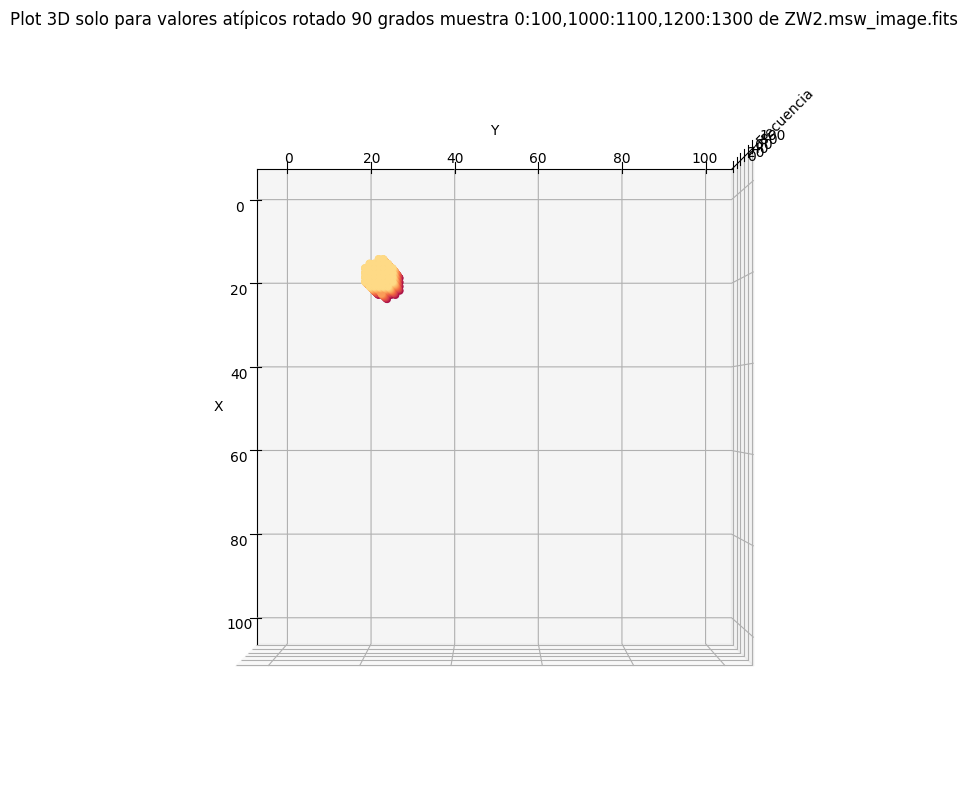

In [79]:
muestra=hdul[0].data[0:100,1000:1100,1200:1300]
suf="muestra 0:100,1000:1100,1200:1300 de ZW2.msw_image.fits"
graf_3d(muestra,atipicos=False, sufix=suf)
graf_3d(muestra,sufix=suf)
graf_3d(muestra,invertir_z=True,sufix=suf)
graf_3d(muestra,atipicos=False,rotate=True,sufix=suf)
graf_3d(muestra,rotate=True,sufix=suf)

### 3.2 Muestra ZW2.msn_image.fits

##### 3.2.1 Muestra aleatoria ZW2.msn_image.fits

Número de imágenes: 901

Muestra aleatoria de ejemplo, imagen: 156
 [[0.00654554 0.00672992 0.00720555 ... 0.0112889  0.01125851 0.01124678]
 [0.00681027 0.00693909 0.00685233 ... 0.01059295 0.01088349 0.01118723]
 [0.00719547 0.00704484 0.00712116 ... 0.00932194 0.01000964 0.01033133]
 ...
 [0.01435587 0.01510547 0.01514545 ... 0.00087615 0.00087621 0.00132457]
 [0.01484505 0.01461388 0.01466218 ... 0.00086632 0.0014734  0.00181129]
 [0.01488711 0.01494349 0.01483192 ... 0.00130622 0.00184273 0.00226478]]
Tamaño de la imagen: (2048, 2048)

Descripción del vector de la imagen:
 count    4.194304e+06
mean     1.096672e-04
std      4.537566e-02
min     -2.248247e-01
25%     -1.256577e-02
50%     -4.191292e-05
75%      1.019680e-02
max      3.557025e+00
dtype: float64
Se han eliminado 0 valores nulos.

Representación de la distribución de la muestra


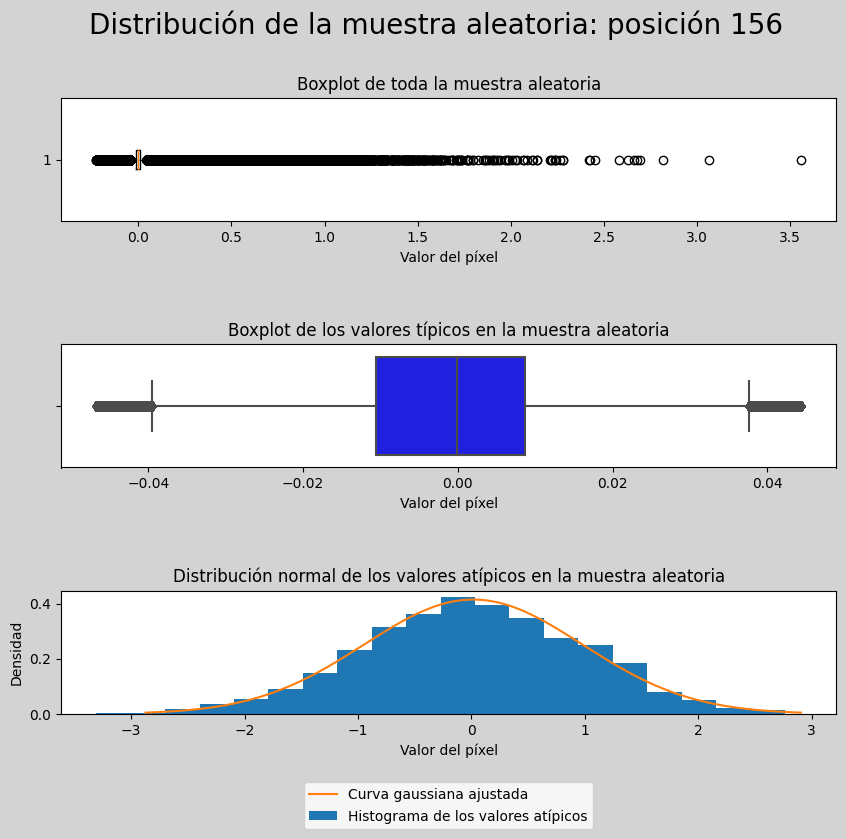

In [80]:
muestra_aleatoria(hdul2[0].data)

##### 3.2.2 Análisis de valores atípicos de ZW2.msn_image.fits

In [81]:
filtrado_atipicos=filtrar_cubo(hdul2[0].data, len_muestra=16)

##### 3.2.2.1 Test Barlett

In [82]:
test_bartlett(filtrado_atipicos)

Las varianzas son significativamente diferentes (p=0.0000).
Se rechaza la hipótesis nula de homocedasticidad con un nivel de significancia de 0.05.


##### 3.2.2.1 Test Welch

In [83]:
test_welch(filtrado_atipicos)

Rechazamos la hipótesis nula de que las medias son iguales. 
Hay evidencia suficiente para afirmar que las medias son significativamente diferentes con un nivel de confianza del 95.0%.


##### 3.2.3 Imágenes de ZW2.msn_image.fits

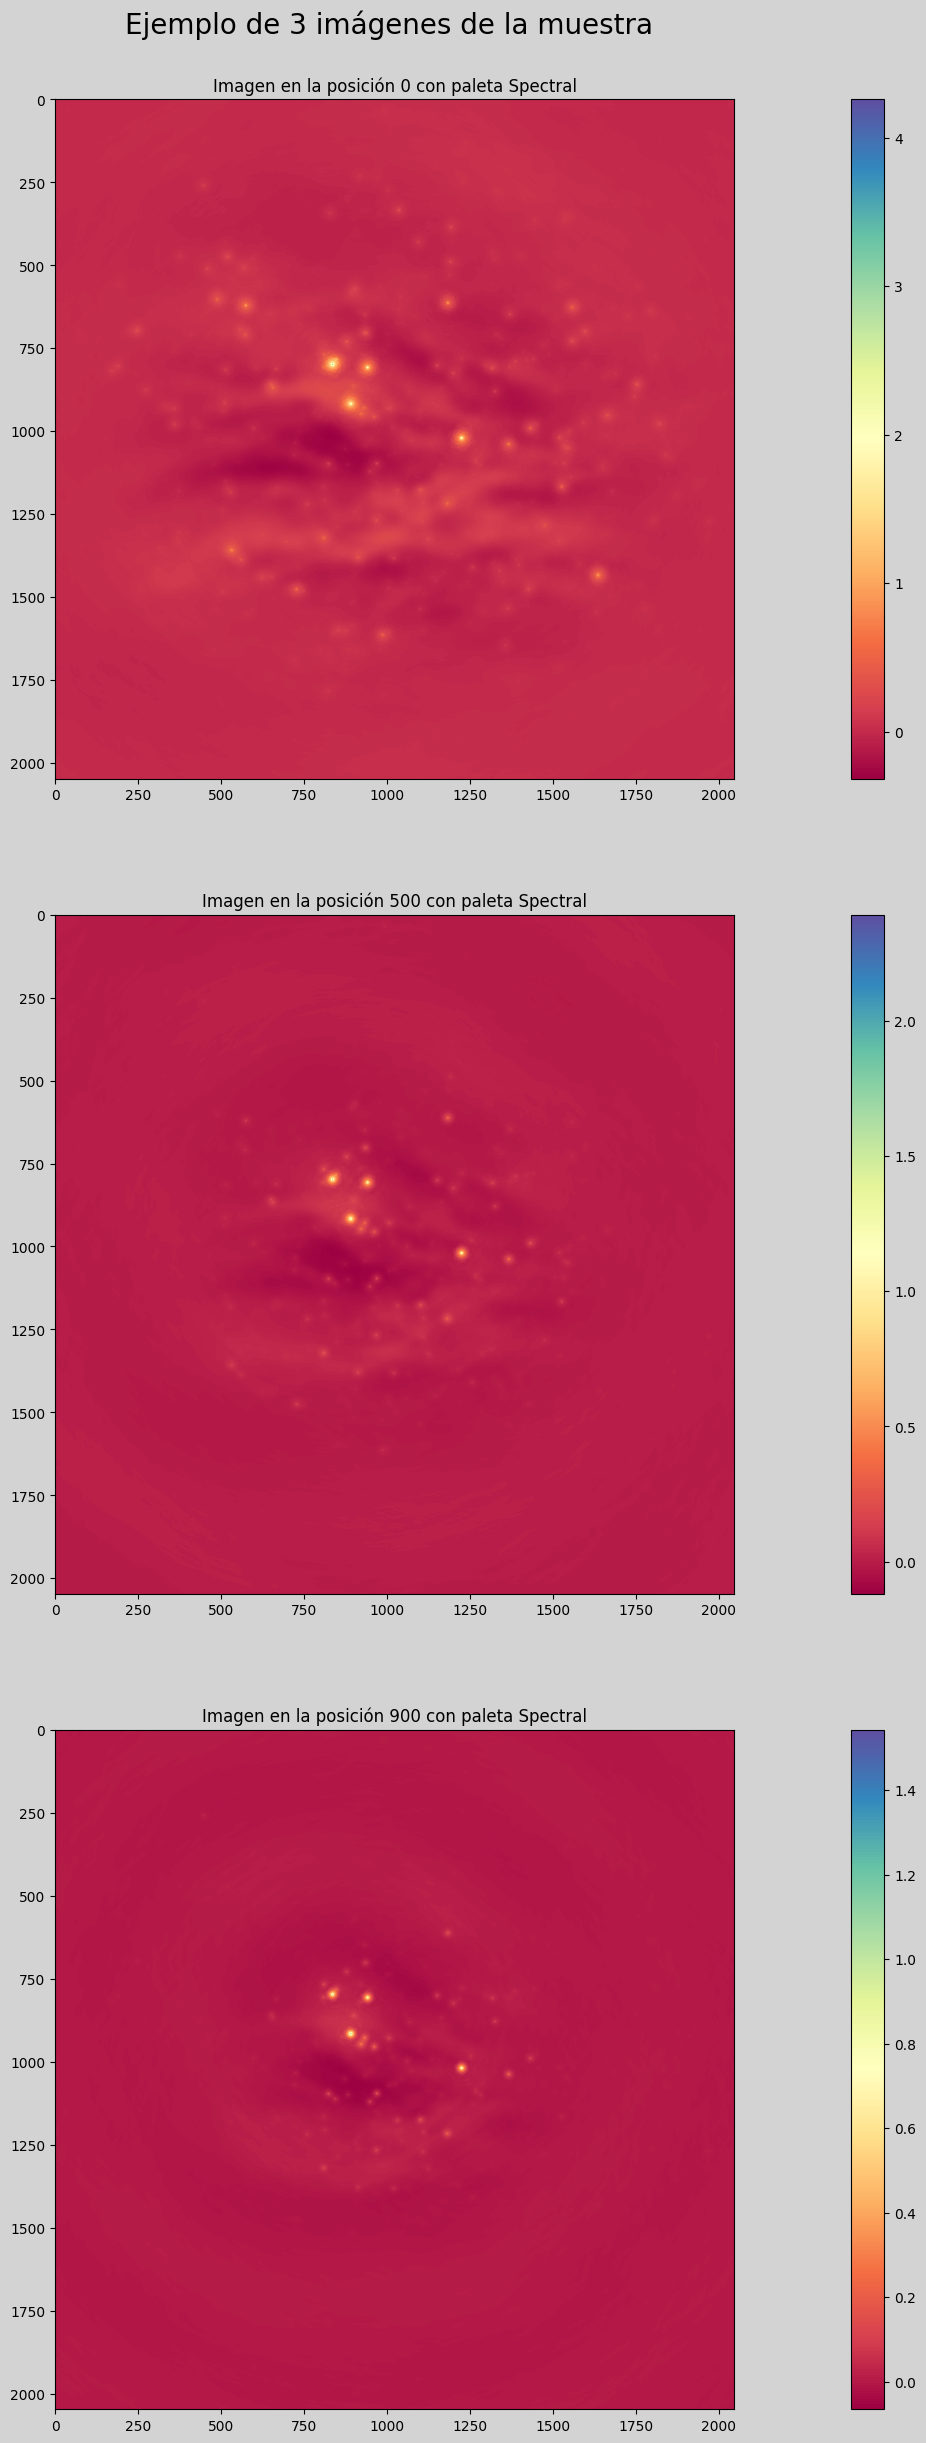

In [84]:
mostrar_imagenes(hdul2[0].data,posiciones=[0,500,900])

##### 3.2.4 Estudio de fuentes de ZW2.msn_image.fits

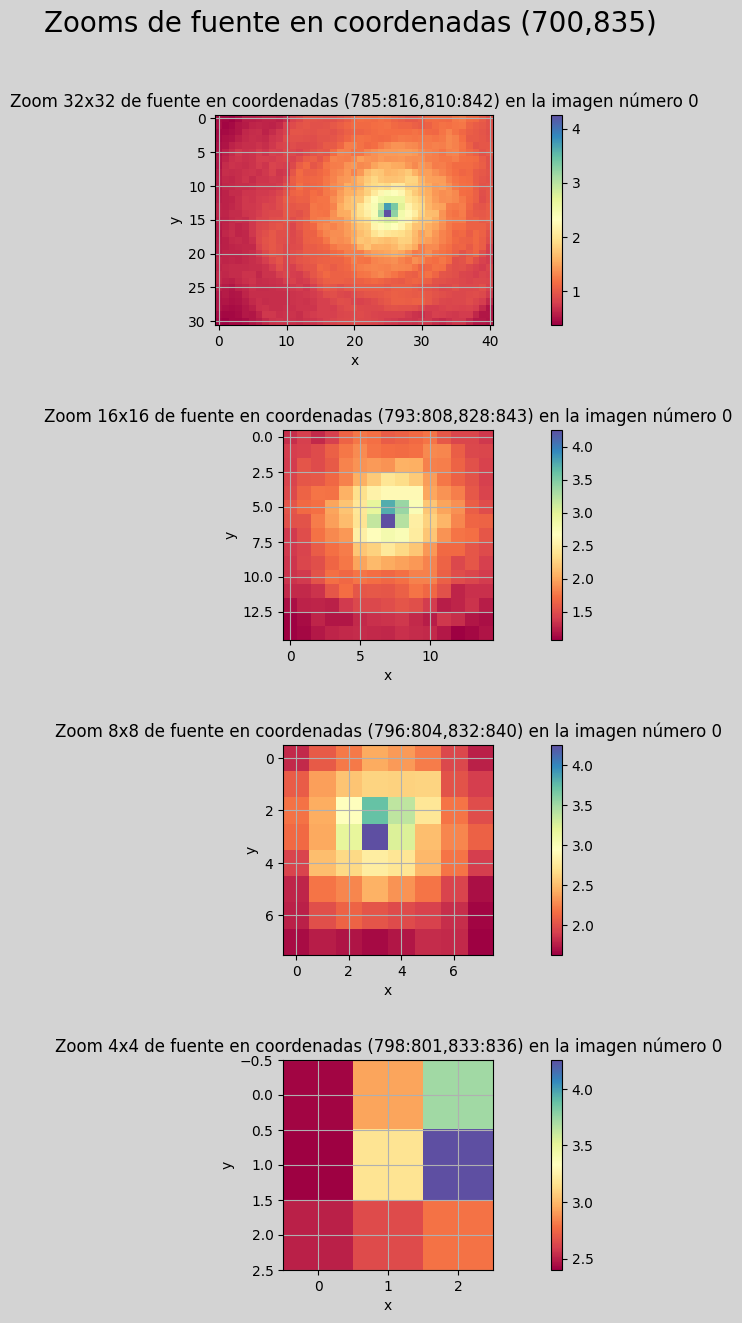

In [108]:
fig, axs = plt.subplots(4, 1, figsize=(15, 15))
fig.suptitle("Zooms de fuente en coordenadas (700,835)",x=0.65,y=0.95, fontsize=20, fontdict={'color':'black', 'weight':'bold', 'horizontalalignment':'center'})
fig.patch.set_facecolor('lightgray')

im4 = axs[0].imshow(hdul2[0].data[0][785:816,810:851],cmap='Spectral')
axs[0].grid(True)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title('Zoom 32x32 de fuente en coordenadas (785:816,810:842) en la imagen número 0')
fig.colorbar(im4, ax=axs[0])


im1 = axs[1].imshow(hdul2[0].data[0][793:808,828:843],cmap='Spectral')
axs[1].grid(True)
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_title('Zoom 16x16 de fuente en coordenadas (793:808,828:843) en la imagen número 0')
fig.colorbar(im1, ax=axs[1])

im2 = axs[2].imshow(hdul2[0].data[0][796:804,832:840],cmap='Spectral')
axs[2].grid(True)
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_title('Zoom 8x8 de fuente en coordenadas (796:804,832:840) en la imagen número 0')
fig.colorbar(im2, ax=axs[2])

im3 = axs[3].imshow(hdul2[0].data[0][798:801,833:836],cmap='Spectral')
axs[3].grid(True)
axs[3].set_xlabel('x')
axs[3].set_ylabel('y')
axs[3].set_title('Zoom 4x4 de fuente en coordenadas (798:801,833:836) en la imagen número 0')
fig.colorbar(im3, ax=axs[3])
fig.subplots_adjust(hspace=0.5)
plt.show()


Estudiemos más a fondo esta fuente

Text(0.5, 1.0, 'Corte de fuente en coordenadas (790:810,825:845) en la imagen número 0')

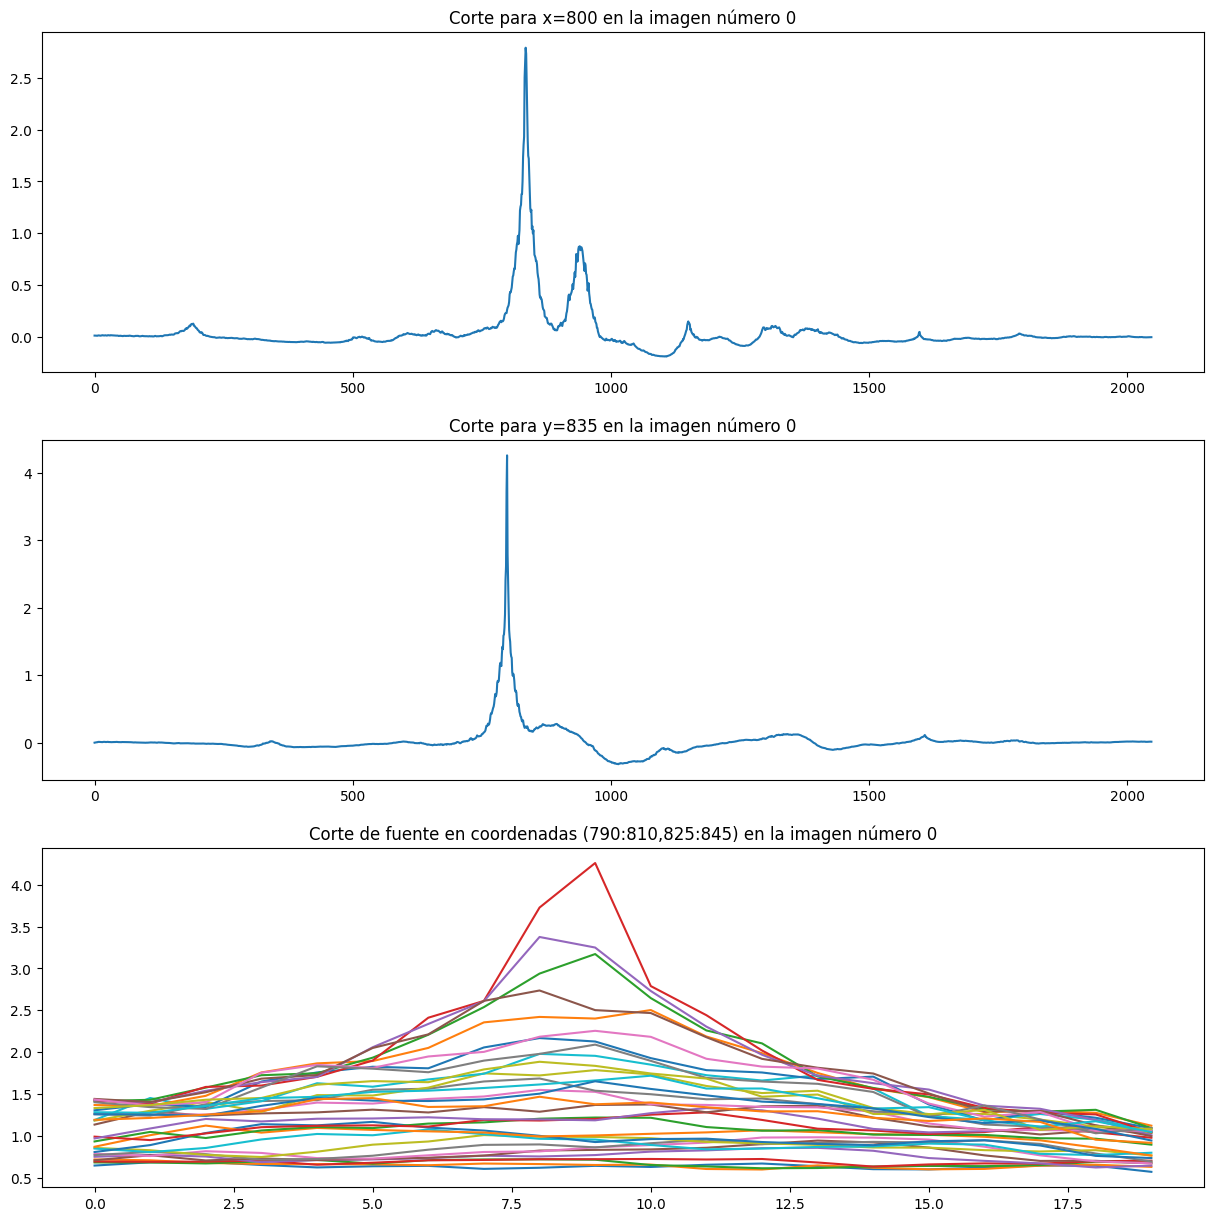

In [86]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))

im1 = axs[0].plot(hdul2[0].data[0][800,:])
axs[0].set_title('Corte para x=800 en la imagen número 0')
im2=axs[1].plot(hdul2[0].data[0][:,835])
axs[1].set_title('Corte para y=835 en la imagen número 0')

im3 = axs[2].plot(hdul2[0].data[0][790:810,812:844])
axs[2].set_title('Corte de fuente en coordenadas (790:810,825:845) en la imagen número 0')



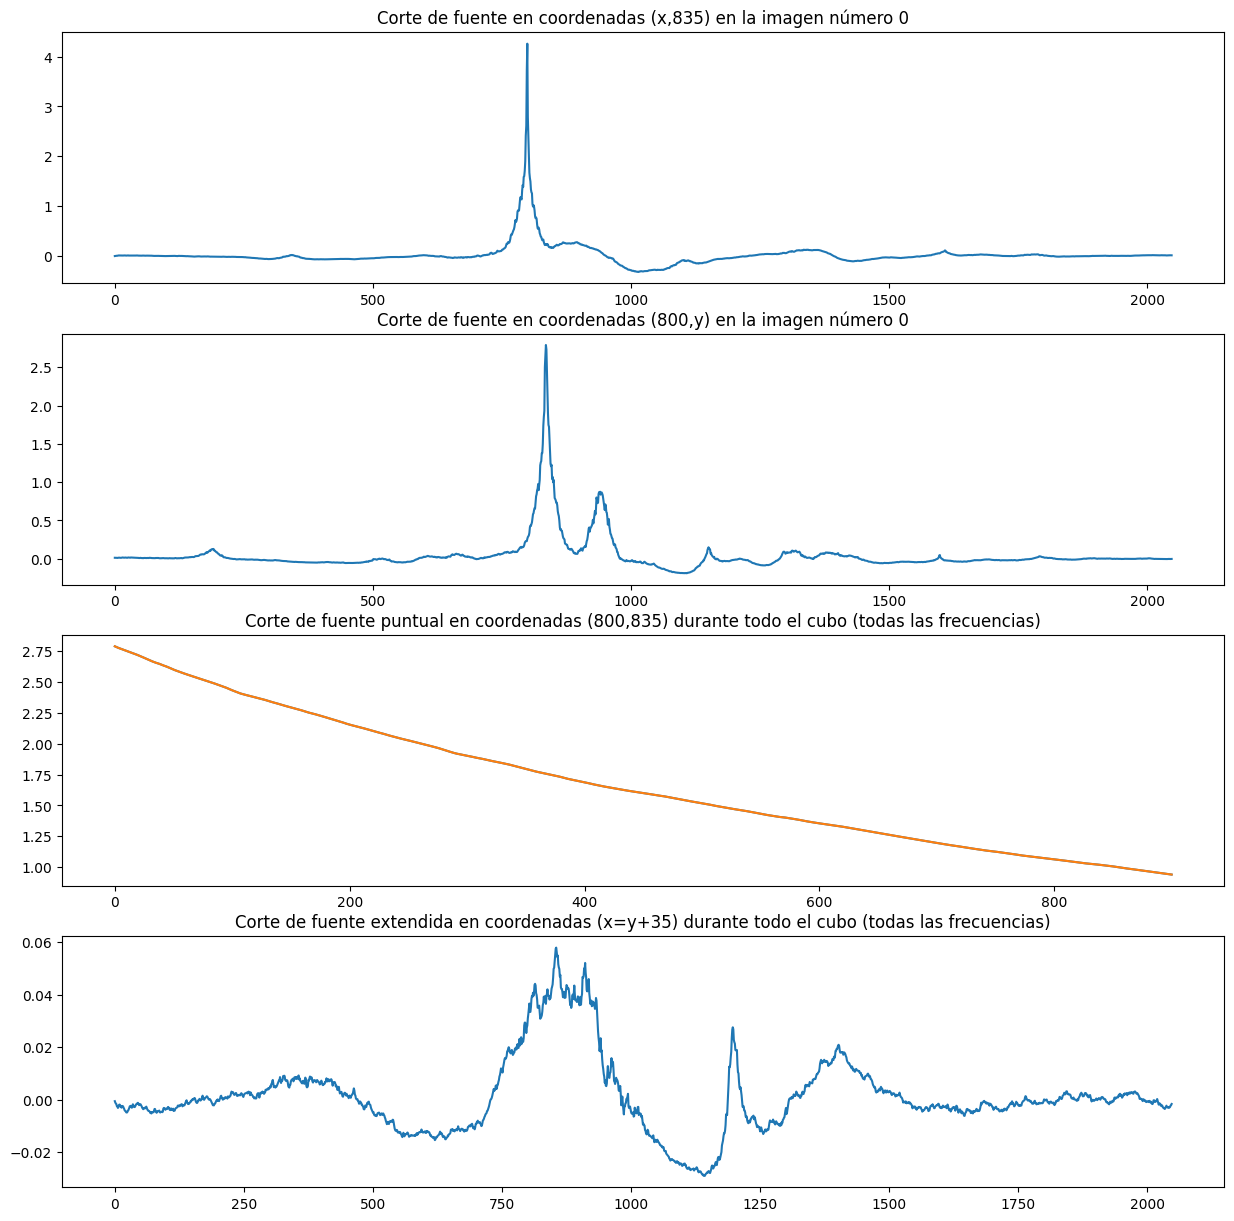

In [87]:
fig, axs = plt.subplots(4, 1, figsize=(15, 15)) 
im1=axs[0].plot(hdul2[0].data[0,:,835]) 
axs[0].set_title('Corte de fuente en coordenadas (x,835) en la imagen número 0') 
im2=axs[1].plot(hdul2[0].data[0,800,:]) 
axs[1].set_title('Corte de fuente en coordenadas (800,y) en la imagen número 0') 
im3=axs[2].plot(hdul2[0].data[:,800,835]) 
im3=axs[2].plot(hdul2[0].data[:,800,835])
axs[2].set_title('Corte de fuente puntual en coordenadas (800,835) durante todo el cubo (todas las frecuencias)')
im4=axs[3].plot(hdul2[0].data[:][800,835])
axs[3].set_title('Corte de fuente extendida en coordenadas (x=y+35) durante todo el cubo (todas las frecuencias)')
axs[3].set_xticks(np.arange(0,len(hdul2[0].data[:][800]),250))

Usando hdul2[0].data[:][800,835] tomamos el valor 800 de la segunda dimensión (x) y el valor 835 de la tercera dimensión (y) para cada valor de la primera dimensión (frecuencia). Es decir, para cada frecuencia, tomas un punto del plano (x,y) que cumple que x=800 y y=835. Si hacemos esto para todas las frecuencias, obtenemos una línea diagonal en el plano (x,y) que cumple que y=x+35. Por ejemplo, si la frecuencia es 0, el punto es (800,835), si la frecuencia es 1, el punto es (801,836), si la frecuencia es 2, el punto es (802,837), y así sucesivamente. Esto sirve para ver cómo varía la intensidad de la fuente en función de la frecuencia y de la posición. Si la coordenada (800,835) es una galaxia, entonces el primer gráfico (hdul2[0].data[:,800,835]) mostramos el espectro de esa galaxia en una posición fija. El segundo gráfico (hdul2[0].data[:][800,835]) muestra el espectro de una línea diagonal que pasa por esa galaxia. Esto es útil para ver las variaciones espaciales en el espectro de la galaxia.

Vamos a estudiarla para distintos intervalos de frecuencia
##### Intervalos 0-100

/tmp/ipykernel_3780219/1146068806.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_scale = plt.cm.get_cmap('Spectral')


<Axes3D: title={'center': 'Plot 3D solo para valores atípicos rotado 90 grados muestra 0:100,790:810,812:844 de ZW2.msn_image.fits'}, xlabel='X', ylabel='Y', zlabel='Frecuencia'>

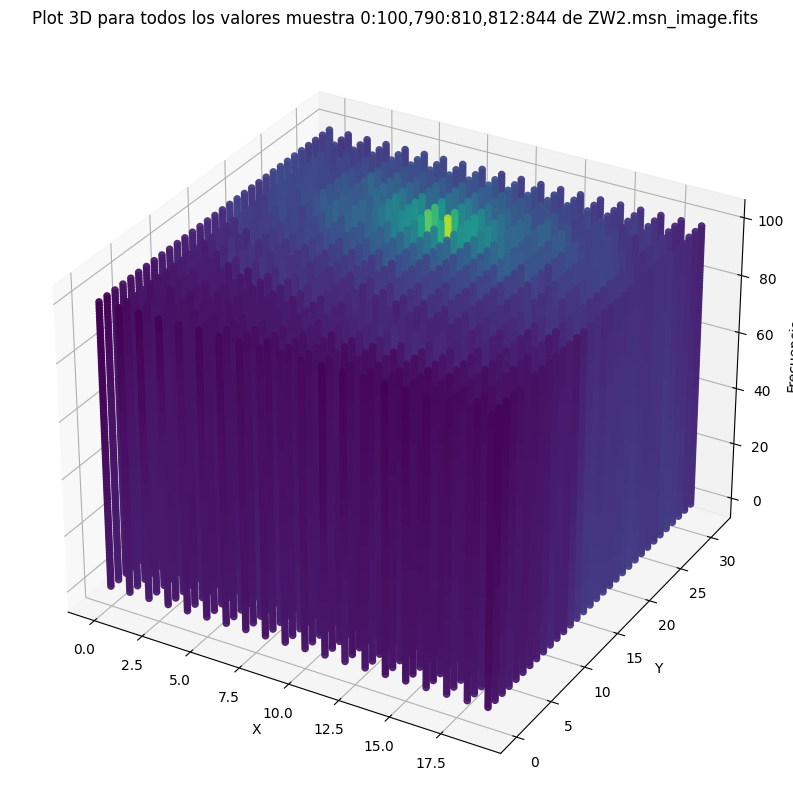

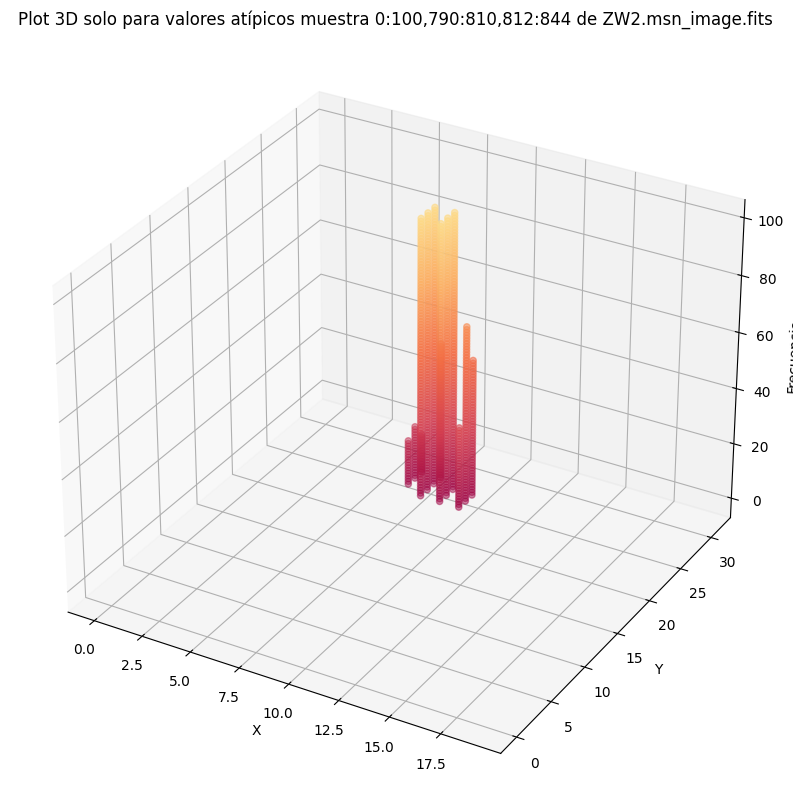

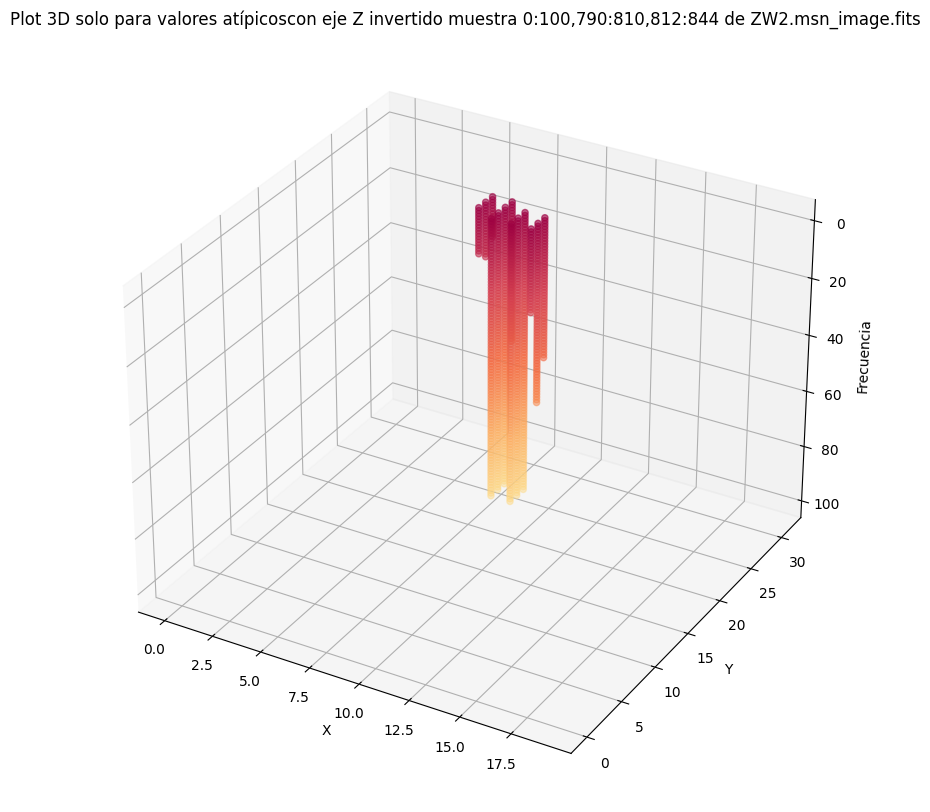

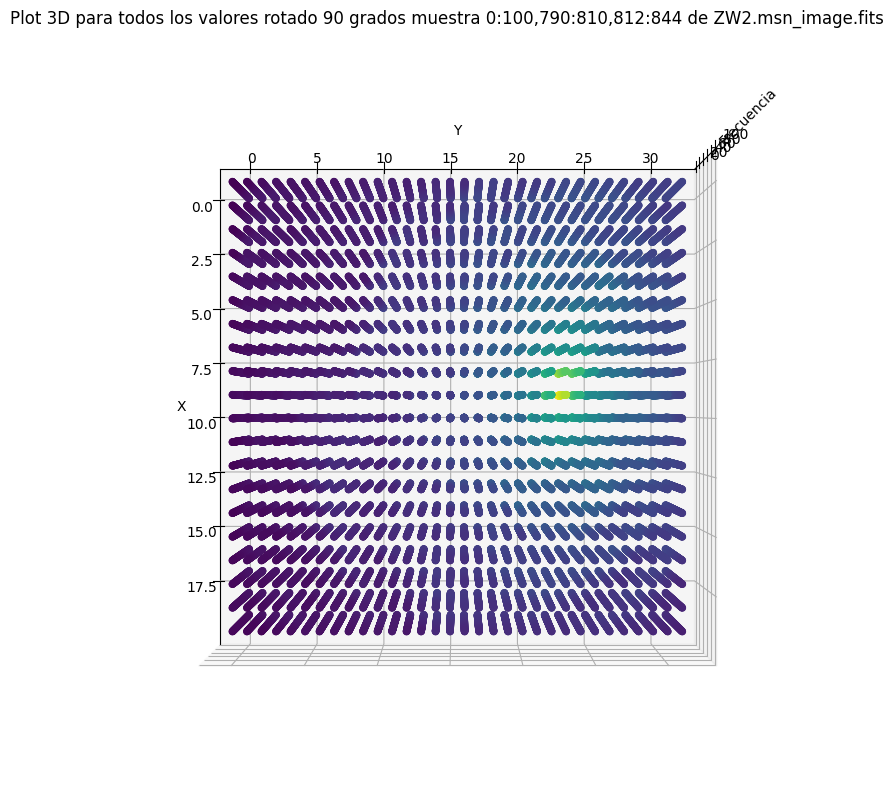

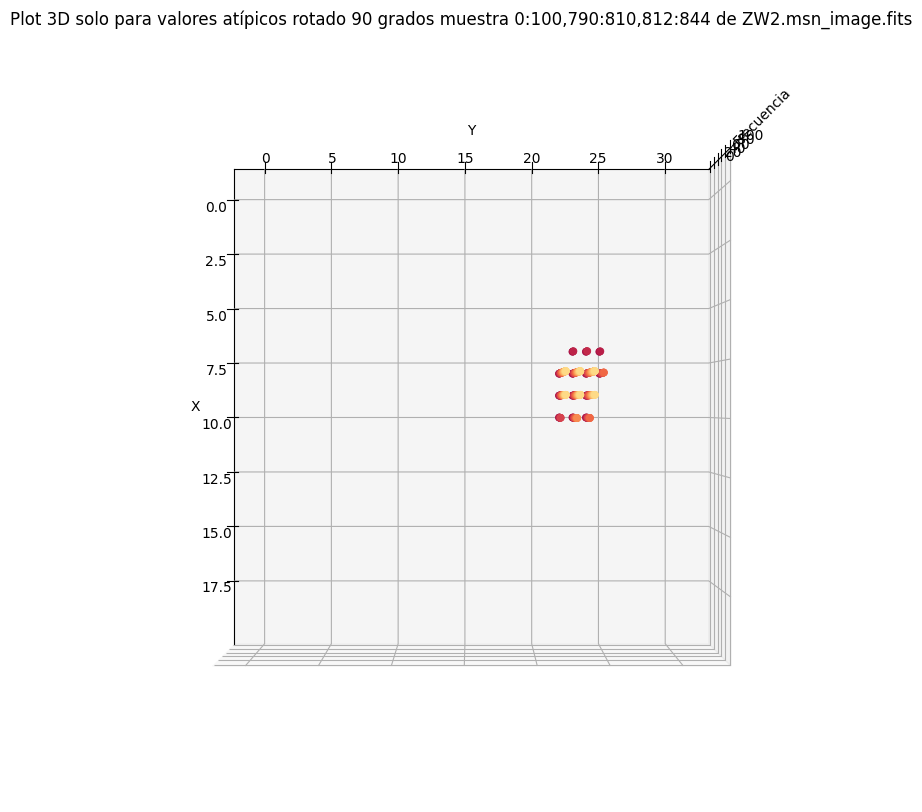

In [88]:
muestra=hdul2[0].data[0:100,790:810,812:844]
suf="muestra 0:100,790:810,812:844 de ZW2.msn_image.fits"
graf_3d(muestra,atipicos=False, sufix=suf)
graf_3d(muestra,sufix=suf)
graf_3d(muestra,invertir_z=True,sufix=suf)
graf_3d(muestra,atipicos=False,rotate=True,sufix=suf)
graf_3d(muestra,rotate=True,sufix=suf)


Las primeras frecuencias presentan más valores atípicos relativos a esta fuente. Veamos cómo se distribuye la fuente en todas las frecuencias

/tmp/ipykernel_3780219/1146068806.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_scale = plt.cm.get_cmap('Spectral')


<Axes3D: title={'center': 'Plot 3D solo para valores atípicos rotado 90 grados muestra 0:100,790:810,812:844 de ZW2.msn_image.fits'}, xlabel='X', ylabel='Y', zlabel='Frecuencia'>

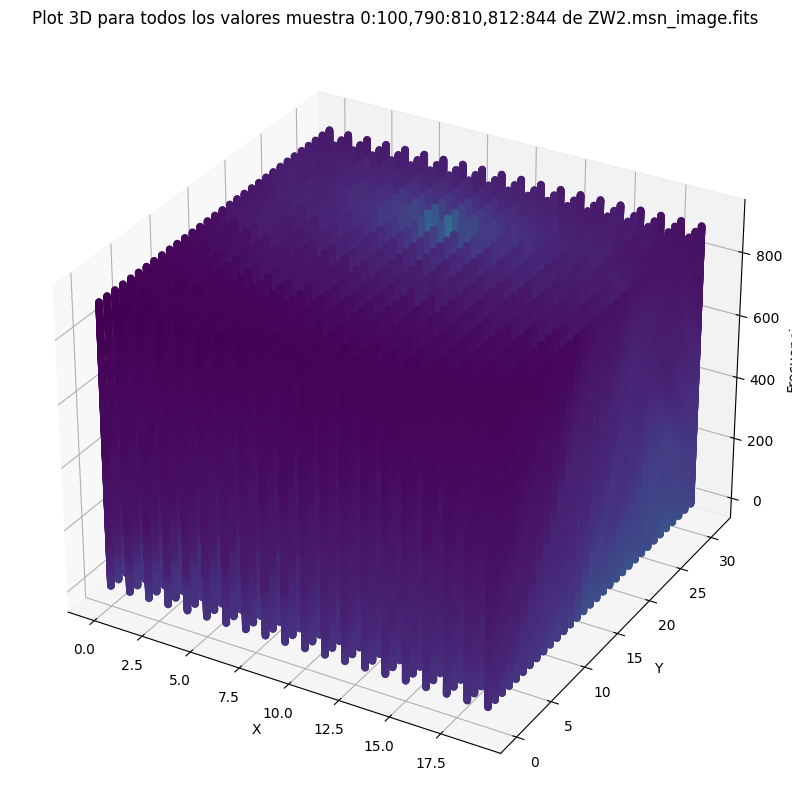

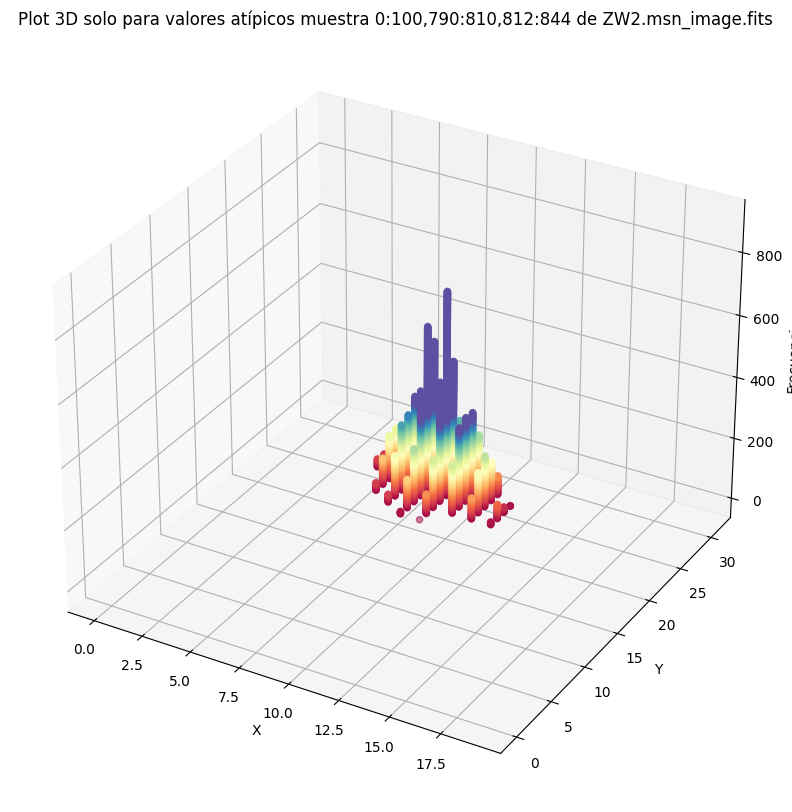

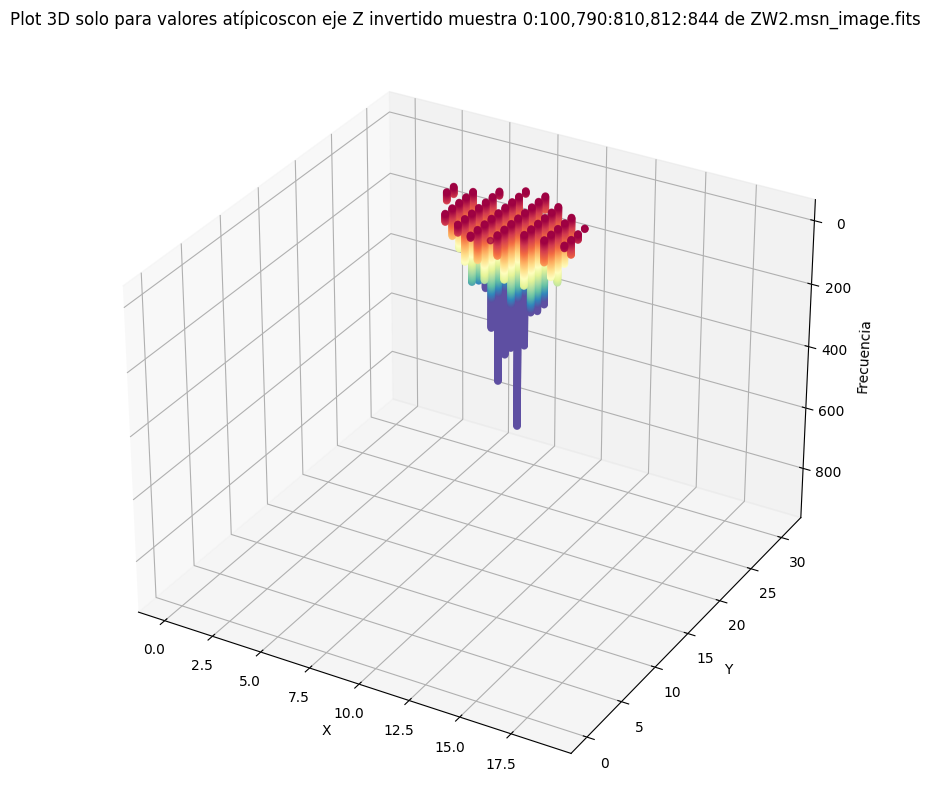

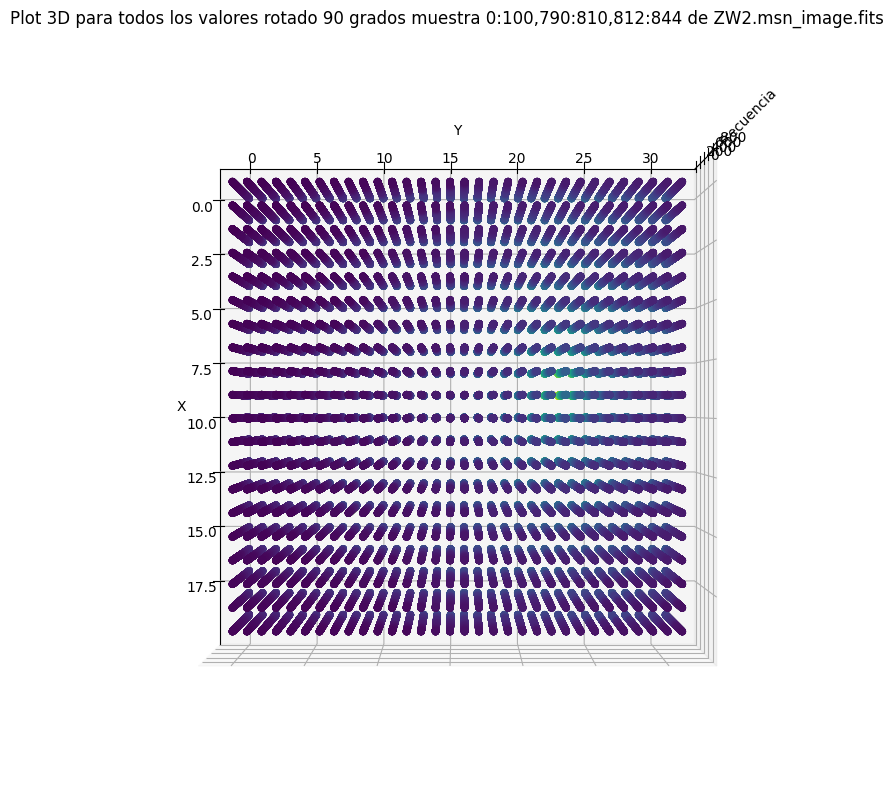

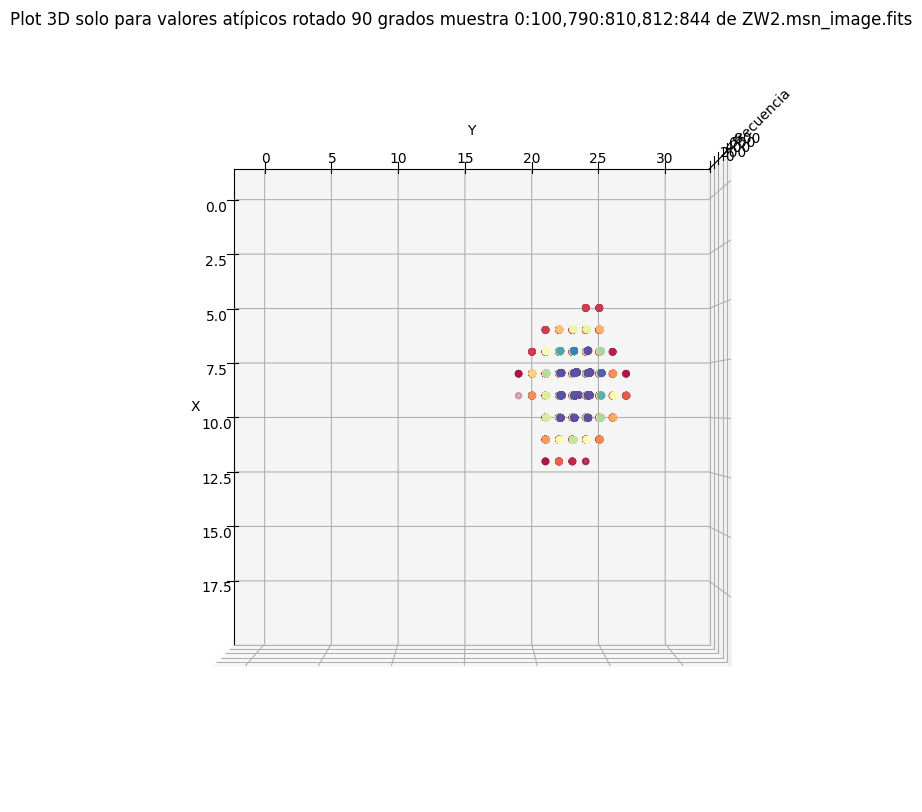

In [89]:
muestra=hdul2[0].data[:,790:810,812:844]
suf="muestra 0:100,790:810,812:844 de ZW2.msn_image.fits"
graf_3d(muestra,atipicos=False, sufix=suf)
graf_3d(muestra,sufix=suf)
graf_3d(muestra,invertir_z=True,sufix=suf)
graf_3d(muestra,atipicos=False,rotate=True,sufix=suf)
graf_3d(muestra,rotate=True,sufix=suf)

Se cumple lo mismo. Los valores centrales se mantienen a lo largo del cubo, pero los periféricos solo se ven en las primeras frecuencias

5 píxeles de full width at high maximum


### 3.3 Muestra ZW2.msn_psf.fits

##### 3.3.1 Muestra aleatoria ZW2.msn_psf.fits

Número de imágenes: 901

Muestra aleatoria de ejemplo, imagen: 243
 [[ 5.2430399e-04  5.3769088e-04  6.2926486e-04 ...  1.0629951e-04
  -3.4260142e-05  8.3229912e-05]
 [ 5.3229410e-04  5.9467292e-04  4.5078323e-04 ...  2.3992627e-04
   1.4983643e-04 -4.4114131e-05]
 [ 5.4750137e-04  4.6212936e-04  3.6449608e-04 ...  2.3118559e-04
   2.3863516e-04  1.6183643e-04]
 ...
 [ 2.2773859e-04  2.2694244e-04  1.7123003e-04 ...  5.0970679e-04
   5.2587345e-04  5.0057285e-04]
 [ 2.3948714e-04  2.4208872e-04  1.3332310e-04 ...  4.6992375e-04
   4.5265598e-04  4.5635516e-04]
 [ 2.1086214e-04  2.9438420e-04  1.7641750e-04 ...  3.5452581e-04
   4.4379244e-04  3.8264345e-04]]
Tamaño de la imagen: (2048, 2048)

Descripción del vector de la imagen:
 count    4.194304e+06
mean    -3.028230e-05
std      3.762277e-03
min     -2.300120e-03
25%     -6.182434e-04
50%     -2.232976e-04
75%      3.581081e-04
max      1.000000e+00
dtype: float64
Se han eliminado 0 valores nulos.

Representación de la distribución

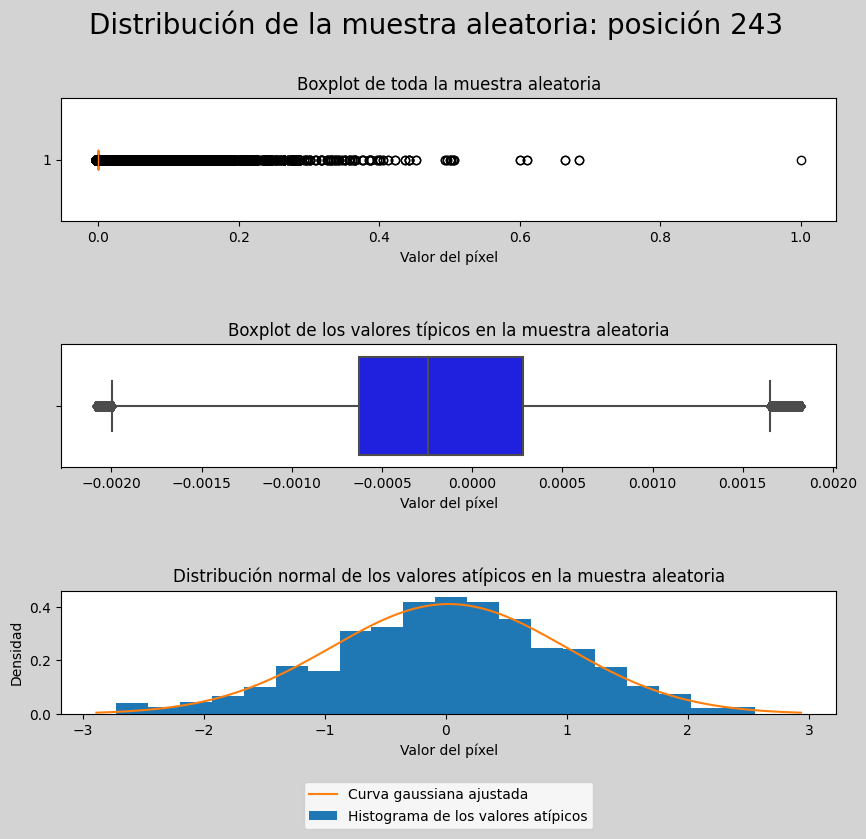

In [92]:
muestra_aleatoria(hdul3[0].data)

##### 3.3.2 Análisis de valores atípicos de ZW2.msn_psf.fits

In [93]:
filtrado_atipicos=filtrar_cubo(hdul3[0].data, len_muestra=16)

##### 3.3.2.1 Test Barlett

In [94]:
test_bartlett(filtrado_atipicos)

Las varianzas son significativamente diferentes (p=0.0000).
Se rechaza la hipótesis nula de homocedasticidad con un nivel de significancia de 0.05.


##### 3.3.2.1 Test Welch

In [95]:
test_welch(filtrado_atipicos)

Rechazamos la hipótesis nula de que las medias son iguales. 
Hay evidencia suficiente para afirmar que las medias son significativamente diferentes con un nivel de confianza del 95.0%.


##### 3.3.3 Imágenes de ZW2.msn_psf.fits

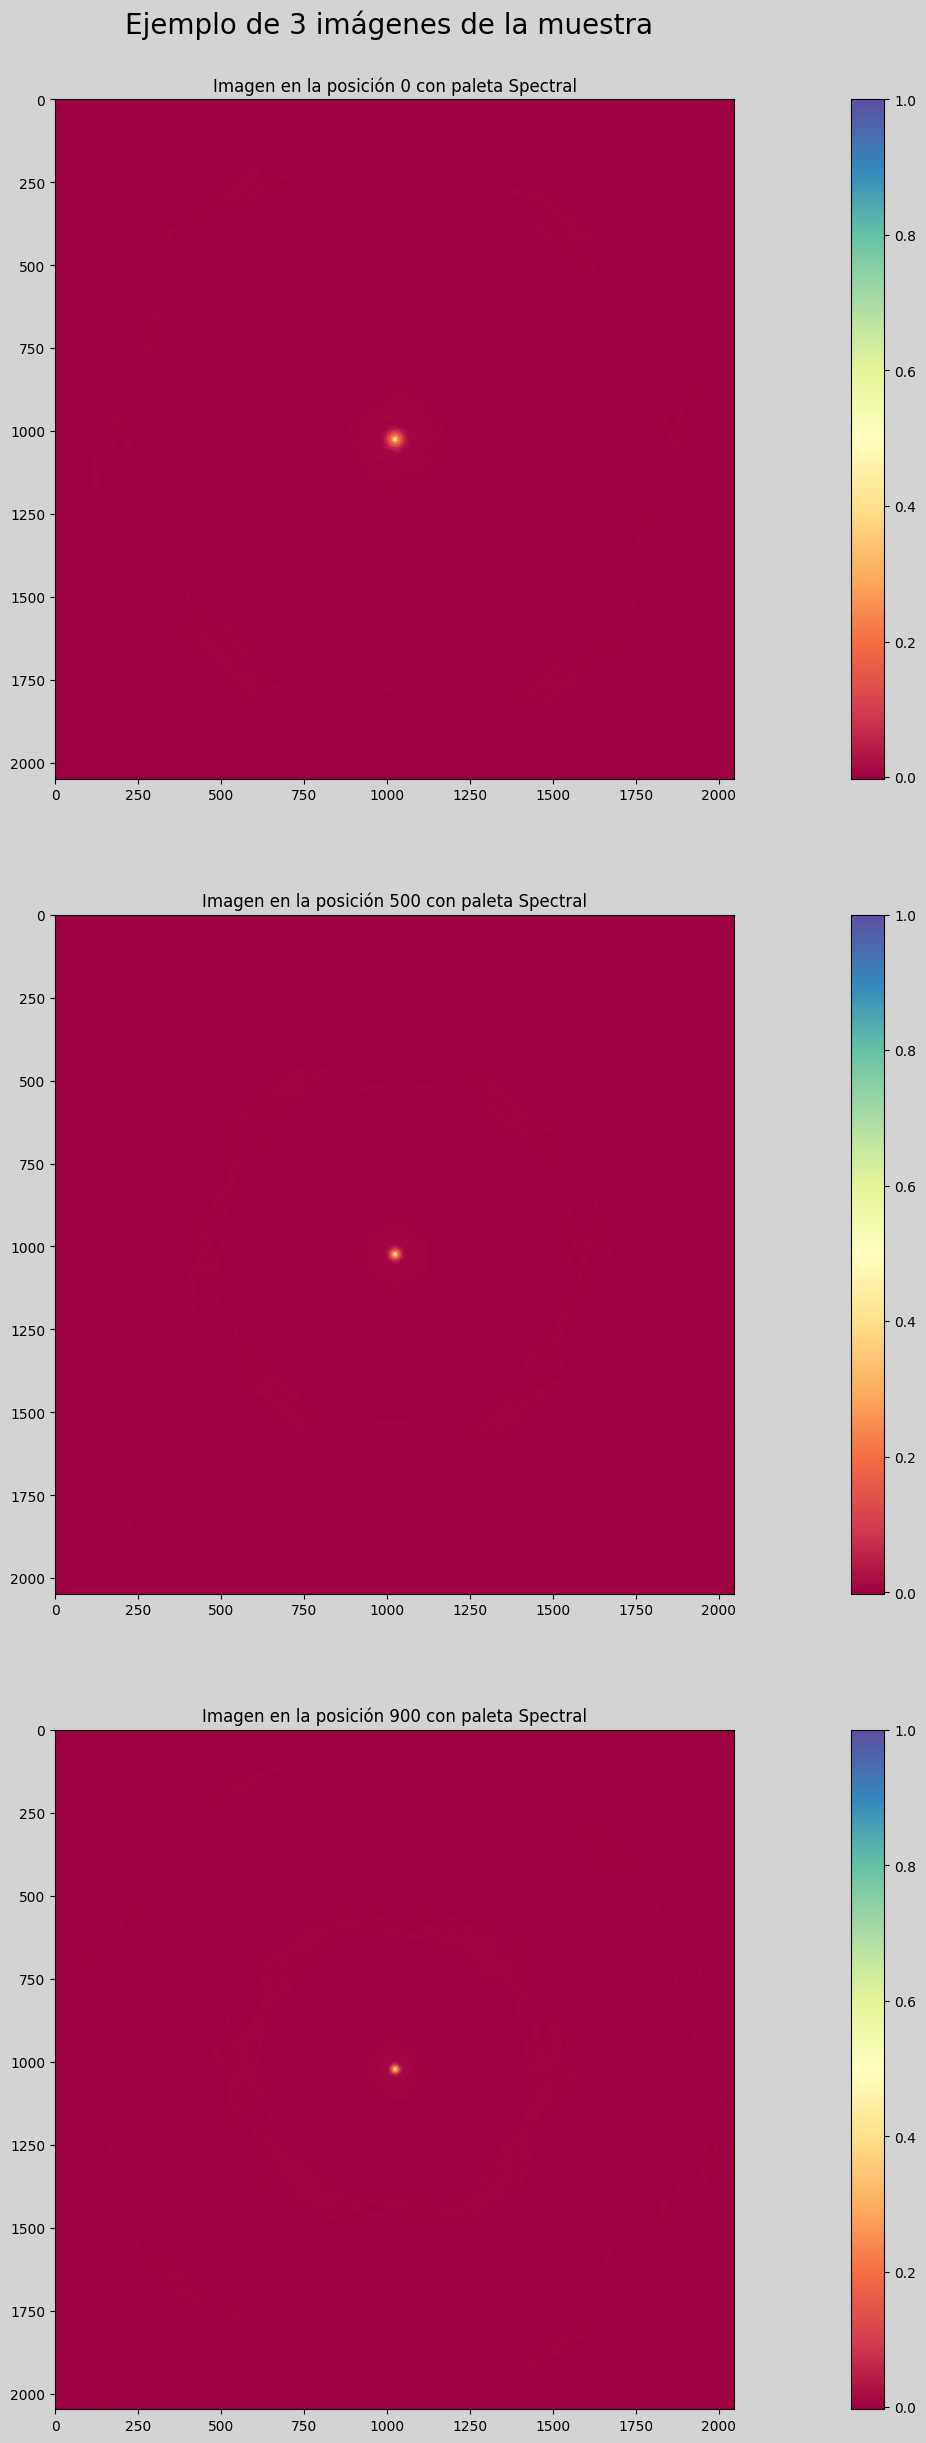

In [96]:
mostrar_imagenes(hdul3[0].data,posiciones=[0,500,900])

##### 3.3.4 Estudio de fuentes de ZW2.msn_psf.fits

Solo hay una única fuente aquí, exactamente en el centro de la imagen

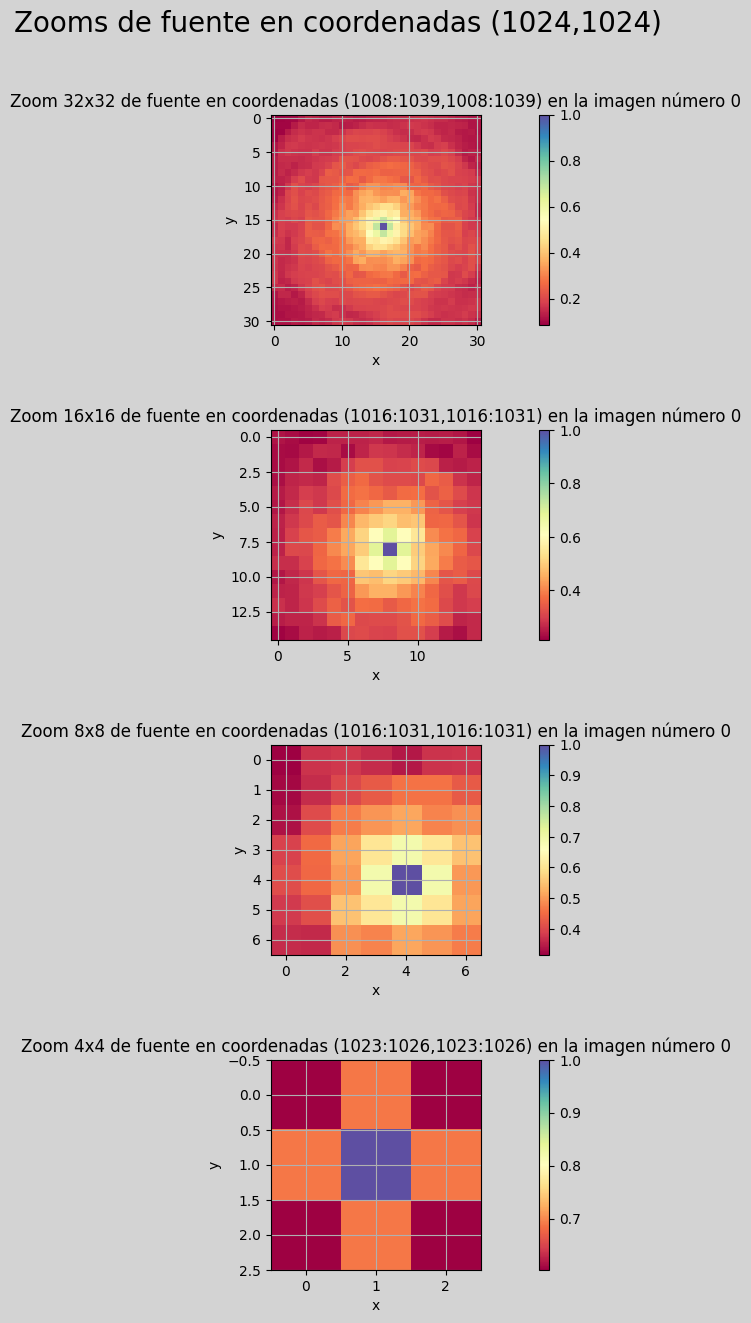

In [116]:
fig, axs = plt.subplots(4, 1, figsize=(15, 15))
fig.suptitle("Zooms de fuente en coordenadas (1024,1024)",x=0.65,y=0.95, fontsize=20, fontdict={'color':'black', 'weight':'bold', 'horizontalalignment':'center'})
fig.patch.set_facecolor('lightgray')

im4 = axs[0].imshow(hdul3[0].data[0][1008:1039,1008:1039],cmap='Spectral')
axs[0].grid(True)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title('Zoom 32x32 de fuente en coordenadas (1008:1039,1008:1039) en la imagen número 0')
fig.colorbar(im4, ax=axs[0])


im1 = axs[1].imshow(hdul3[0].data[0][1016:1031,1016:1031],cmap='Spectral')
axs[1].grid(True)
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_title('Zoom 16x16 de fuente en coordenadas (1016:1031,1016:1031) en la imagen número 0')
fig.colorbar(im1, ax=axs[1])

im2 = axs[2].imshow(hdul3[0].data[0][1020:1027,1020:1027],cmap='Spectral')
axs[2].grid(True)
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_title('Zoom 8x8 de fuente en coordenadas (1016:1031,1016:1031) en la imagen número 0')
fig.colorbar(im2, ax=axs[2])

im3 = axs[3].imshow(hdul3[0].data[0][1023:1026,1023:1026],cmap='Spectral')
axs[3].grid(True)
axs[3].set_xlabel('x')
axs[3].set_ylabel('y')
axs[3].set_title('Zoom 4x4 de fuente en coordenadas (1023:1026,1023:1026) en la imagen número 0')
fig.colorbar(im3, ax=axs[3])
fig.subplots_adjust(hspace=0.5)
plt.show()

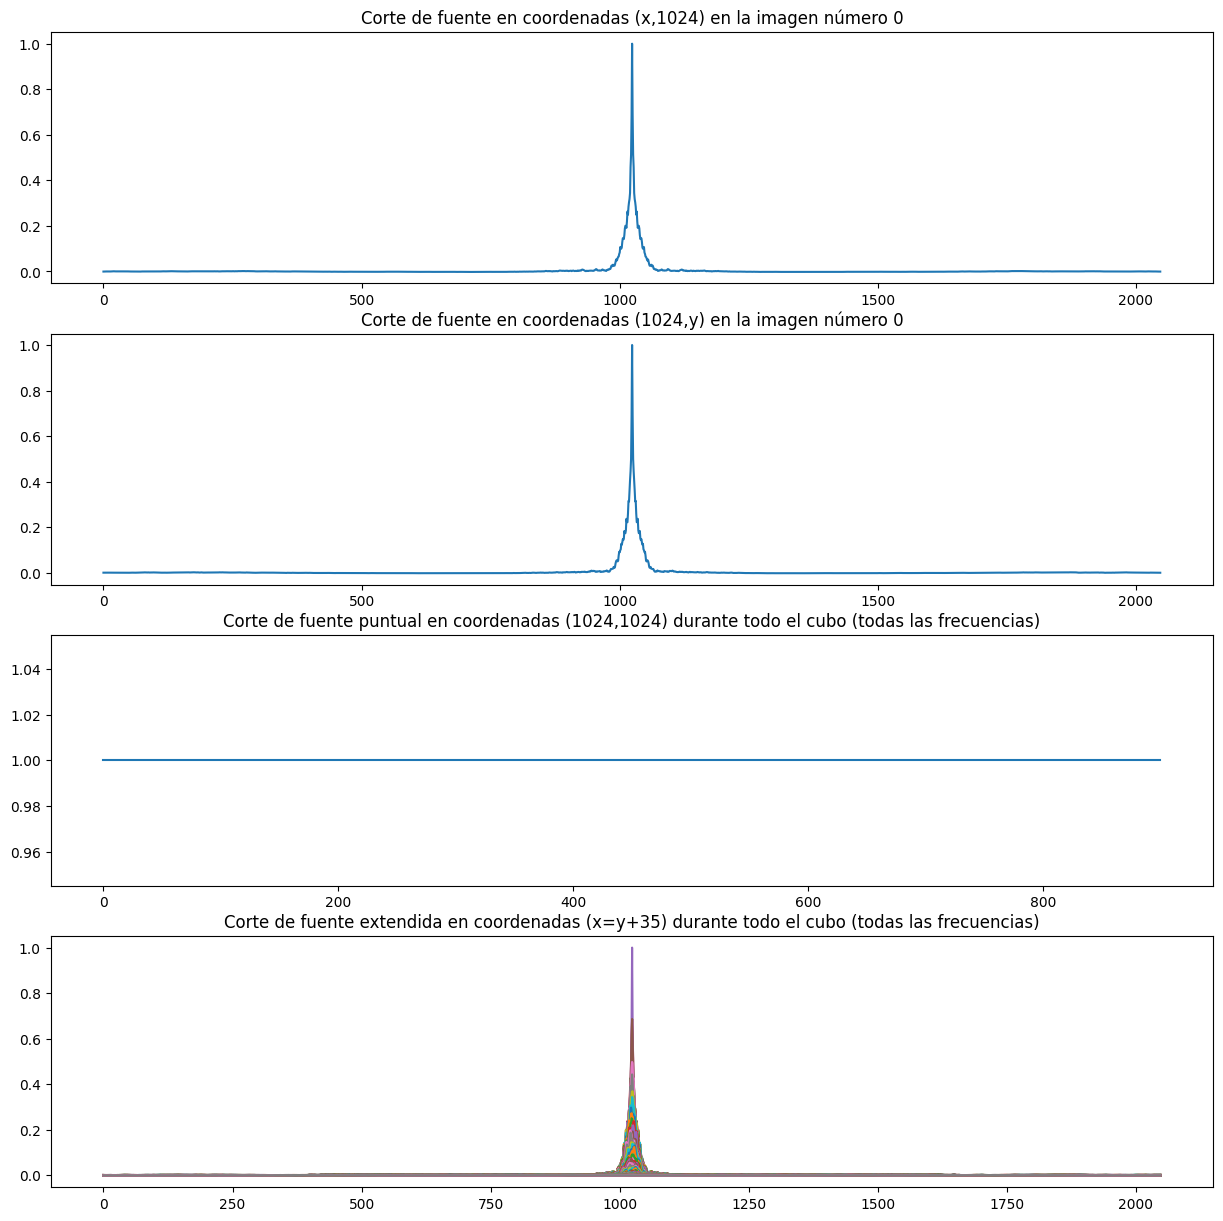

In [136]:
fig, axs = plt.subplots(4, 1, figsize=(15, 15)) 
im1=axs[0].plot(hdul3[0].data[0,:,1024]) 
axs[0].set_title('Corte de fuente en coordenadas (x,1024) en la imagen número 0') 
im2=axs[1].plot(hdul3[0].data[0,1024,:]) 
axs[1].set_title('Corte de fuente en coordenadas (1024,y) en la imagen número 0') 
im3=axs[2].plot(hdul3[0].data[:,1024,1024]) 
axs[2].set_title('Corte de fuente puntual en coordenadas (1024,1024) durante todo el cubo (todas las frecuencias)')
im4=axs[3].plot(hdul3[0].data[:][:][450])
axs[3].set_title('Corte de fuente extendida en coordenadas (x=y+35) durante todo el cubo (todas las frecuencias)')
axs[3].set_xticks(np.arange(0,len(hdul2[0].data[:][800]),250))